In [1]:
import pandas as pd
import os
from pathlib import Path
from pyalex import Works, Authors, Sources, Institutions, Topics, Publishers, Funders
from pyalex import config
from tqdm import tqdm 
import json

In [9]:
from scipy.stats import ttest_ind, mannwhitneyu
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import ast
from scipy.stats import f_oneway, kruskal

In [52]:
from pyalex import config

config.email = "rde6mn@virginia.edu"
config.max_retries = 5
config.retry_backoff_factor = 0.1
config.retry_http_codes = [429, 500, 503]

In [2]:
df = pd.read_csv('combined_teams_with_all_openalex.csv')

In [5]:
import pandas as pd
import requests

# Example: your df
# df = pd.read_csv("your_file.csv")

def fetch_work_ids(openalex_id):
    try:
        url = f"https://api.openalex.org/works?filter=author.id:{openalex_id}"
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()

        work_ids = [
            item["id"].replace("https://openalex.org/", "")
            for item in data.get("results", [])
            if "id" in item and item["id"].startswith("https://openalex.org/W")
        ]
        return work_ids
    except Exception as e:
        print(f"Error fetching for {openalex_id}: {e}")
        return []

# Apply to df
df['OpenAlex_Work_IDs'] = df['AllOpenAlex_ID'].apply(fetch_work_ids)


Error fetching for nan: 403 Client Error: FORBIDDEN for url: https://api.openalex.org/works?filter=author.id:nan
Error fetching for nan: 403 Client Error: FORBIDDEN for url: https://api.openalex.org/works?filter=author.id:nan
Error fetching for nan: 403 Client Error: FORBIDDEN for url: https://api.openalex.org/works?filter=author.id:nan
Error fetching for nan: 403 Client Error: FORBIDDEN for url: https://api.openalex.org/works?filter=author.id:nan
Error fetching for nan: 403 Client Error: FORBIDDEN for url: https://api.openalex.org/works?filter=author.id:nan
Error fetching for nan: 403 Client Error: FORBIDDEN for url: https://api.openalex.org/works?filter=author.id:nan
Error fetching for nan: 403 Client Error: FORBIDDEN for url: https://api.openalex.org/works?filter=author.id:nan
Error fetching for nan: 403 Client Error: FORBIDDEN for url: https://api.openalex.org/works?filter=author.id:nan
Error fetching for nan: 403 Client Error: FORBIDDEN for url: https://api.openalex.org/works?filt

In [6]:
df.to_csv('team_roster_with_all_works.csv')

In [11]:
df = pd.read_csv('team_roster_with_all_works.csv')

In [13]:
df = df[df['Role'].isin(['Lead PI', 'Co-PI', 'Lead-PI'])]

In [14]:
df['Role'].unique()

array(['Lead-PI', 'Co-PI', 'Lead PI'], dtype=object)

In [17]:
list_cols_to_str = ['OpenAlex_Work_IDs']

for col in list_cols_to_str:
    if col in df.columns:
        df[col] = df[col].apply(lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else x)

In [18]:
import requests
import pandas as pd

def fetch_topics_for_work(work_id):
    """Fetch list of topic IDs for a single work ID."""
    try:
        url = f"https://api.openalex.org/works/{work_id}"
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()

        topics = []
        for topic in data.get("topics", []):
            if "id" in topic:
                topics.append(topic["id"].replace("https://openalex.org/", ""))
        return topics
    except Exception as e:
        print(f"Error fetching topics for work {work_id}: {e}")
        return []

def fetch_topics_for_author(work_id_list):
    """Fetch all topic IDs (with duplicates) for a list of work IDs."""
    all_topics = []
    for wid in work_id_list:
        all_topics.extend(fetch_topics_for_work(wid))
    return all_topics

# Apply to DataFrame
df["ListOfTopics"] = df["OpenAlex_Work_IDs"].apply(fetch_topics_for_author)


Error fetching topics for work W2313589960: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
Error fetching topics for work W3022457072: HTTPSConnectionPool(host='api.openalex.org', port=443): Max retries exceeded with url: /works/W3022457072 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000017E0364F890>: Failed to resolve 'api.openalex.org' ([Errno 11001] getaddrinfo failed)"))
Error fetching topics for work W2971459875: HTTPSConnectionPool(host='api.openalex.org', port=443): Max retries exceeded with url: /works/W2971459875 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000017E0364F250>: Failed to resolve 'api.openalex.org' ([Errno 11001] getaddrinfo failed)"))
Error fetching topics for work W2970402865: HTTPSConnectionPool(host='api.openalex.org', port=443): Max retries exceeded with url: /works/W2970402865 (Caused by NameResolu

In [20]:
df.to_csv('team_roster_with_works_and_topics.csv')

In [21]:
import pandas as pd

# Step 1: Get all unique topics across all people, preserve order
all_unique_topics = sorted(set(topic for topics in df["ListOfTopics"] for topic in topics))

# Step 2: Assign this as the "vector positions" column (same for all rows)
df["TopicVectorPositions"] = [all_unique_topics] * len(df)

# Step 3: Create the topic count vector for each row
def make_topic_vector(person_topics, all_topics):
    counts = [person_topics.count(topic) for topic in all_topics]
    return counts

df["TopicVector"] = df["ListOfTopics"].apply(lambda topics: make_topic_vector(topics, all_unique_topics))


In [23]:
df.to_csv('team_roster_with_topic_vector.csv')

In [2]:
df = pd.read_csv('team_roster_with_subfield_vector.csv')

In [3]:
df['Team'] = df['Team'].str.replace("Team ", "", regex=False)

In [4]:
supplement_df = pd.read_excel('Supplement Grants by Team.xlsx')

In [5]:
supplement_df.columns

Index(['Team', 'Supplement', 'Category'], dtype='object')

In [6]:
wave_df = pd.read_csv('ASAP Rounds - Sheet1.csv')

In [7]:
accept_df = pd.read_excel('renewal_info_from_robert.xlsx')

In [11]:
wave_df.columns

Index(['Team', 'Round'], dtype='object')

In [12]:
accept_df.columns

Index(['Team', 'Renewal'], dtype='object')

In [10]:
def parse_vector(x):
    if isinstance(x, str):
        try:
            return np.array(ast.literal_eval(x), dtype=float)
        except:
            return np.nan
    return x

df["SubFieldVector"] = df["SubFieldVector"].apply(parse_vector)
df["TopicVector"] = df["TopicVector"].apply(parse_vector)

In [14]:
df = pd.merge(df, wave_df, on="Team", how="inner")

In [15]:
df = pd.merge(df, accept_df, on="Team", how="inner")

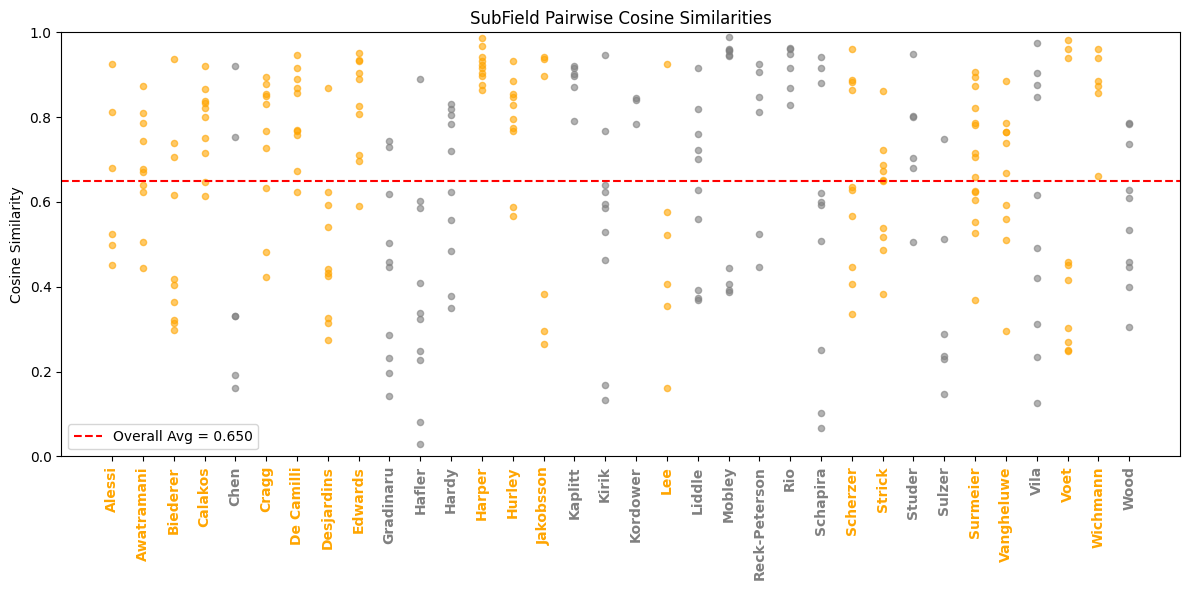

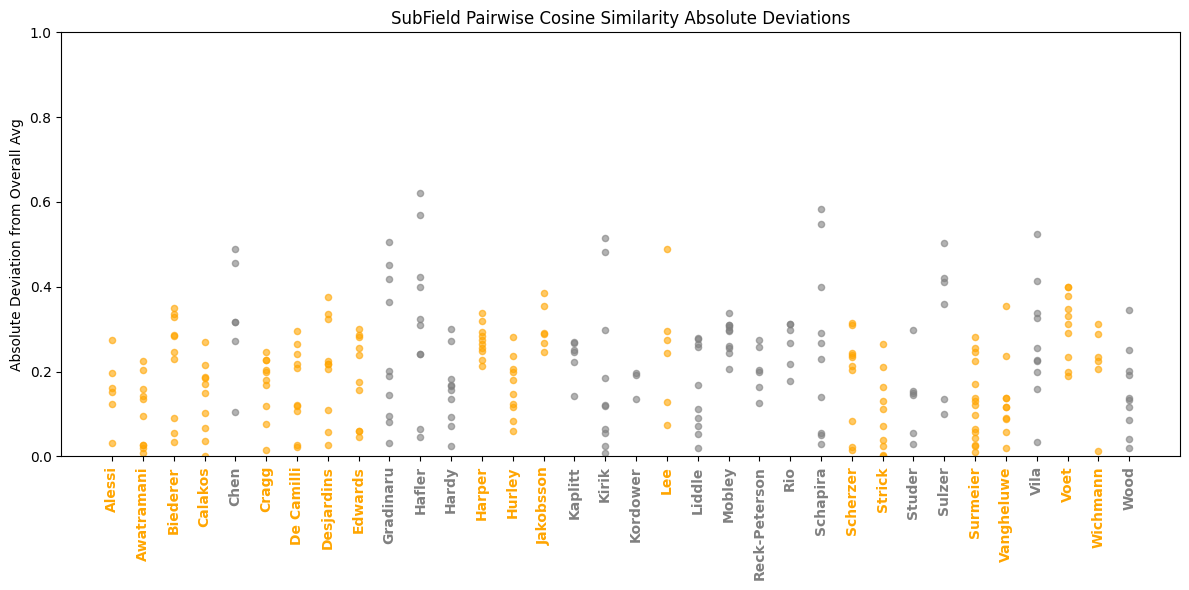

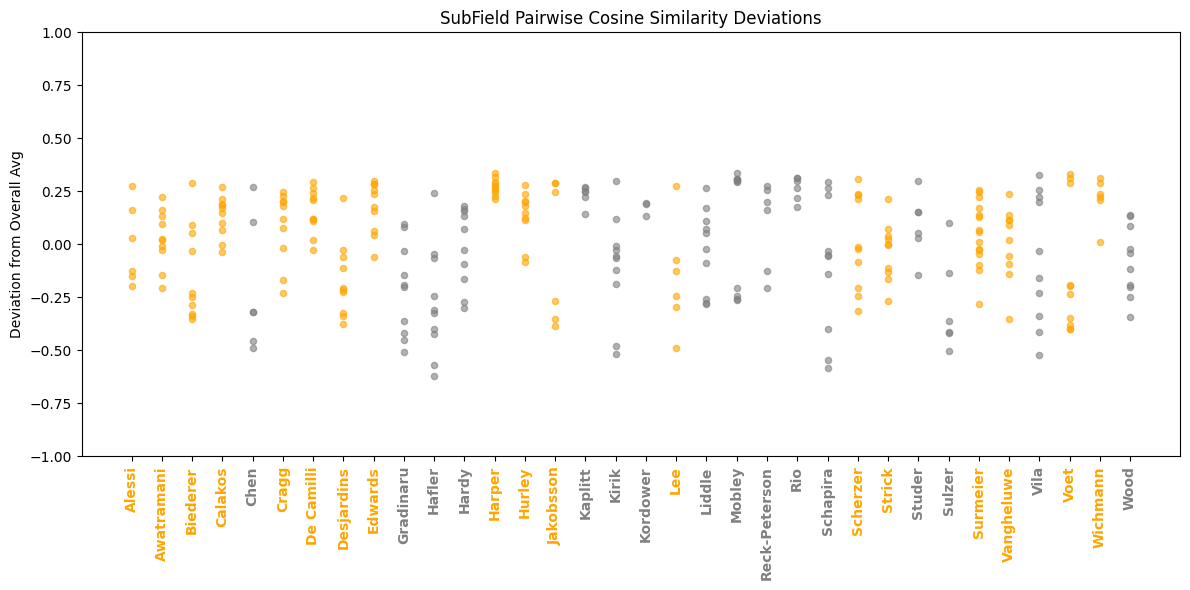

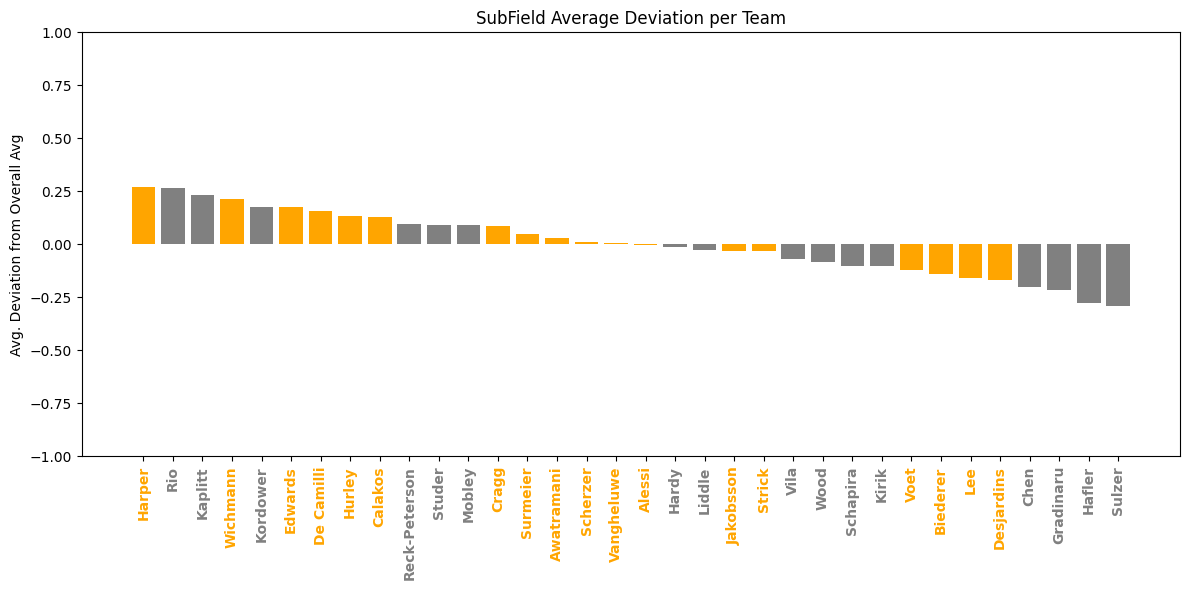

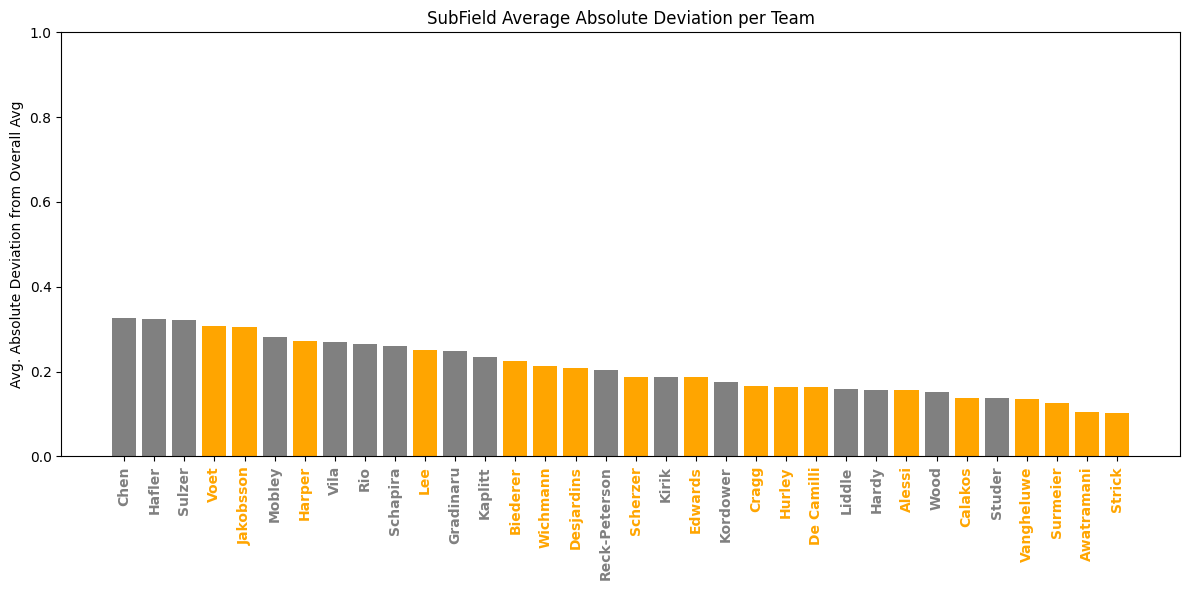

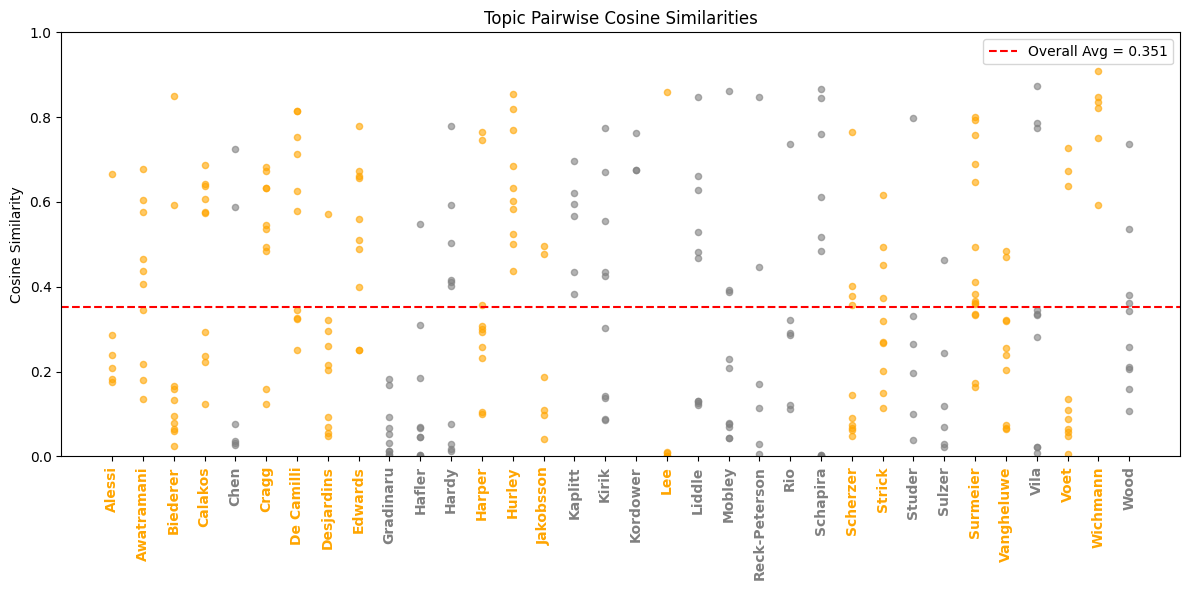

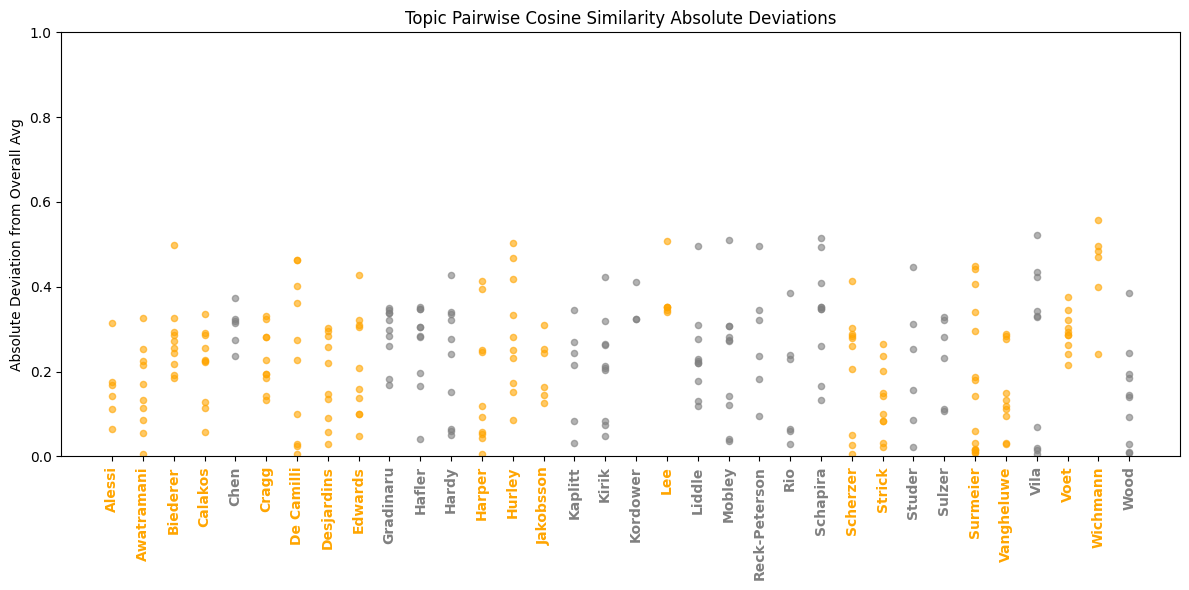

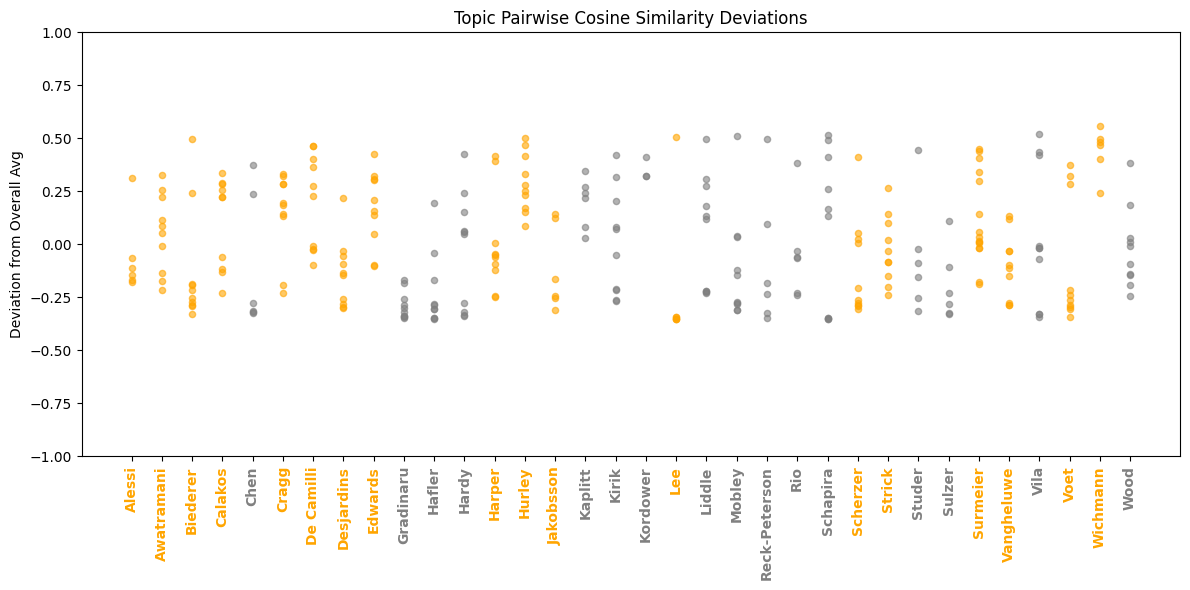

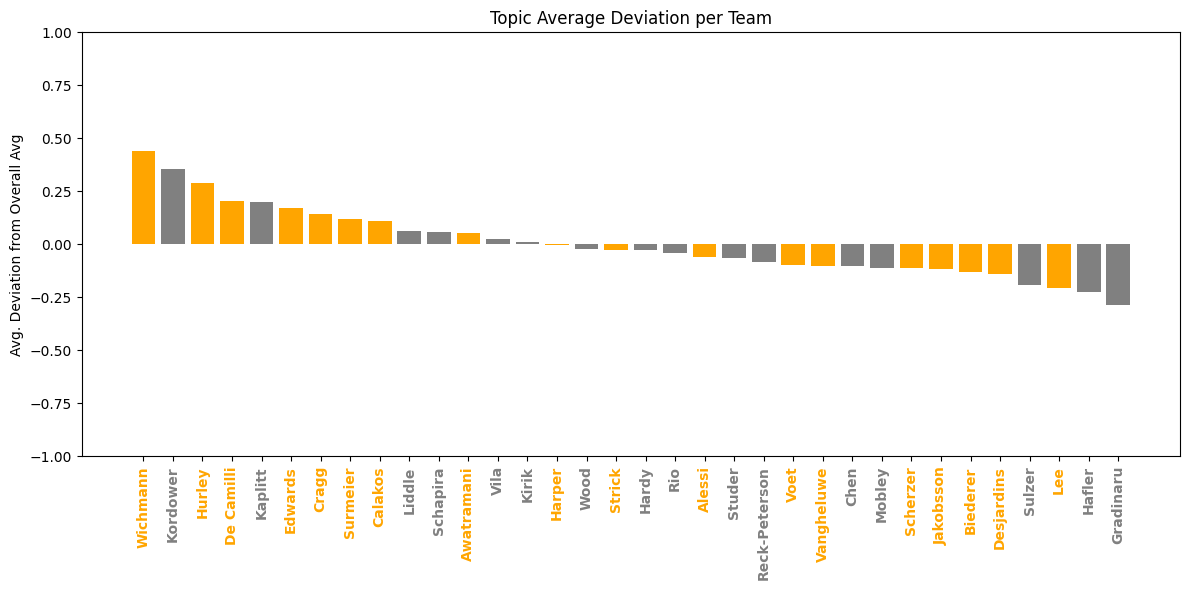

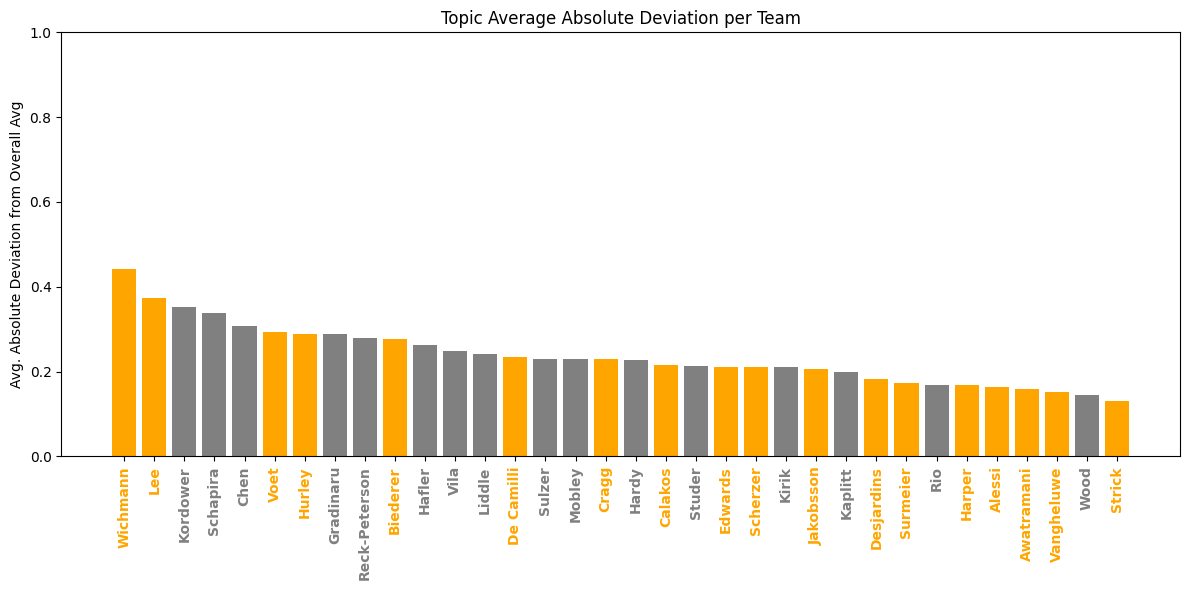

In [19]:
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def compute_pairwise_sims(df, vector_col, supplement_df):
    """
    Computes pairwise cosine similarities for each team 
    given a vector column (SubFieldVector or TopicVector).
    """
    team_pairwise_sims = {}
    team_colors = {
        row.Team: ("orange" if row.Supplement == "Yes" else "grey")
        for _, row in supplement_df.iterrows()
    }

    for team, group in df.groupby("Team"):
        vectors = np.vstack(group[vector_col].values)
        sim_matrix = cosine_similarity(vectors)

        pairwise = [
            sim_matrix[i, j] 
            for i, j in itertools.combinations(range(len(group)), 2)
        ]
        team_pairwise_sims[team] = pairwise

    # Flatten all pairwise similarities to get global average
    all_sims = [sim for sims in team_pairwise_sims.values() for sim in sims]
    overall_avg = np.mean(all_sims) if all_sims else np.nan

    return team_pairwise_sims, team_colors, overall_avg


def make_plots(team_pairwise_sims, team_colors, overall_avg, title_prefix, save_prefix):
    """
    Makes 3 plots:
      1. Scatter of raw similarities per team (line at overall avg).
      2. Scatter of absolute deviation from overall avg per team.
      3. Bar chart of average absolute deviation per team.
    """

    # --- 1. Scatter of raw pairwise similarities ---
    plt.figure(figsize=(12,6))
    for i, (team, sims) in enumerate(team_pairwise_sims.items()):
        x = np.repeat(i, len(sims))
        plt.scatter(x, sims, color=team_colors.get(team, "grey"), alpha=0.6, s=20)
    plt.axhline(overall_avg, color="red", linestyle="--", label=f"Overall Avg = {overall_avg:.3f}")
    plt.xticks(range(len(team_pairwise_sims)), team_pairwise_sims.keys(), rotation=90, fontweight="bold")
    for label, team in zip(plt.gca().get_xticklabels(), team_pairwise_sims.keys()):
        label.set_color(team_colors.get(team, "grey"))
    plt.ylabel("Cosine Similarity")
    plt.title(f"{title_prefix} Pairwise Cosine Similarities")
    plt.ylim(0,1)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{save_prefix}_scatter_raw.png")
    plt.show()

    # --- 2. Scatter of deviations from overall avg ---
    plt.figure(figsize=(12,6))
    for i, (team, sims) in enumerate(team_pairwise_sims.items()):
        deviations = [abs(sim - overall_avg) for sim in sims]
        x = np.repeat(i, len(deviations))
        plt.scatter(x, deviations, color=team_colors.get(team, "grey"), alpha=0.6, s=20)
    plt.xticks(range(len(team_pairwise_sims)), team_pairwise_sims.keys(), rotation=90, fontweight="bold")
    for label, team in zip(plt.gca().get_xticklabels(), team_pairwise_sims.keys()):
        label.set_color(team_colors.get(team, "grey"))
    plt.ylabel("Absolute Deviation from Overall Avg")
    plt.title(f"{title_prefix} Pairwise Cosine Similarity Absolute Deviations")
    plt.ylim(0,1)
    plt.tight_layout()
    plt.savefig(f"{save_prefix}_scatter_absolute_deviation.png")
    plt.show()

    # --- 3. Scatter of deviations from overall avg (non-absolute version)---
    plt.figure(figsize=(12,6))
    for i, (team, sims) in enumerate(team_pairwise_sims.items()):
        deviations = [(sim - overall_avg) for sim in sims]
        x = np.repeat(i, len(deviations))
        plt.scatter(x, deviations, color=team_colors.get(team, "grey"), alpha=0.6, s=20)
    plt.xticks(range(len(team_pairwise_sims)), team_pairwise_sims.keys(), rotation=90, fontweight="bold")
    for label, team in zip(plt.gca().get_xticklabels(), team_pairwise_sims.keys()):
        label.set_color(team_colors.get(team, "grey"))
    plt.ylabel("Deviation from Overall Avg")
    plt.title(f"{title_prefix} Pairwise Cosine Similarity Deviations")
    plt.ylim(-1,1)
    plt.tight_layout()
    plt.savefig(f"{save_prefix}_scatter_deviation.png")
    plt.show()

    # --- 4. Bar chart of average deviations ---
    # Compute average deviations per team
    avg_devs = {team: np.mean([(sim - overall_avg) for sim in sims]) if sims else 0 
                for team, sims in team_pairwise_sims.items()}

    # Sort teams by avg deviation (descending)
    sorted_items = sorted(avg_devs.items(), key=lambda x: x[1], reverse=True)
    teams_sorted = [t for t, _ in sorted_items]
    vals_sorted = [v for _, v in sorted_items]

    plt.figure(figsize=(12,6))
    for team, val in zip(teams_sorted, vals_sorted):
        plt.bar(team, val, color=team_colors.get(team, "grey"))

    plt.xticks(rotation=90, fontweight="bold")
    for label, team in zip(plt.gca().get_xticklabels(), teams_sorted):
        label.set_color(team_colors.get(team, "grey"))

    plt.ylabel("Avg. Deviation from Overall Avg")
    plt.title(f"{title_prefix} Average Deviation per Team")
    plt.ylim(-1,1)
    plt.tight_layout()
    plt.savefig(f"{save_prefix}_bar_avg_deviation_sorted.png")
    plt.show()

    # --- 5. Bar chart of average absolute deviations ---

    abs_avg_devs = {team: np.mean([abs(sim - overall_avg) for sim in sims]) if sims else 0 
                for team, sims in team_pairwise_sims.items()}

    # Sort teams by avg deviation (descending)
    sorted_items = sorted(abs_avg_devs.items(), key=lambda x: x[1], reverse=True)
    teams_sorted = [t for t, _ in sorted_items]
    vals_sorted = [v for _, v in sorted_items]

    plt.figure(figsize=(12,6))
    for team, val in zip(teams_sorted, vals_sorted):
        plt.bar(team, val, color=team_colors.get(team, "grey"))

    plt.xticks(rotation=90, fontweight="bold")
    for label, team in zip(plt.gca().get_xticklabels(), teams_sorted):
        label.set_color(team_colors.get(team, "grey"))

    plt.ylabel("Avg. Absolute Deviation from Overall Avg")
    plt.title(f"{title_prefix} Average Absolute Deviation per Team")
    plt.ylim(0,1)
    plt.tight_layout()
    plt.savefig(f"{save_prefix}_bar_avg_abs_deviation_sorted.png")
    plt.show()

    



# ============================
# Run for both SubField & Topic
# ============================

# --- SubField ---
subfield_pairwise_sims, team_colors, overall_avg_subfield = compute_pairwise_sims(df, "SubFieldVector", supplement_df)
make_plots(subfield_pairwise_sims, team_colors, overall_avg_subfield,
           title_prefix="SubField", save_prefix="subfield")

# --- Topic ---
topic_pairwise_sims, team_colors, overall_avg_topic = compute_pairwise_sims(df, "TopicVector", supplement_df)
make_plots(topic_pairwise_sims, team_colors, overall_avg_topic,
           title_prefix="Topic", save_prefix="topic")


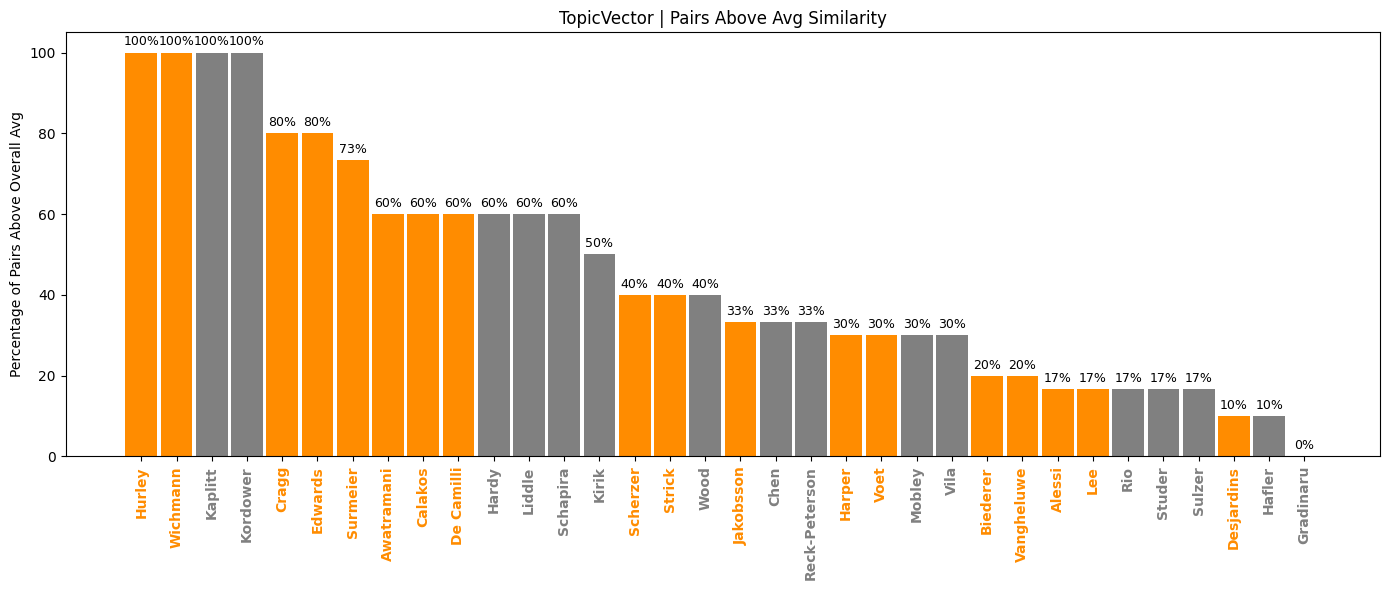

Mean deviation (Yes): 48.3333
Mean deviation (No):  41.0417
Difference: 7.29%
T-test: t=0.725, p=0.4738
Mann–Whitney U: U=167.000, p=0.4345


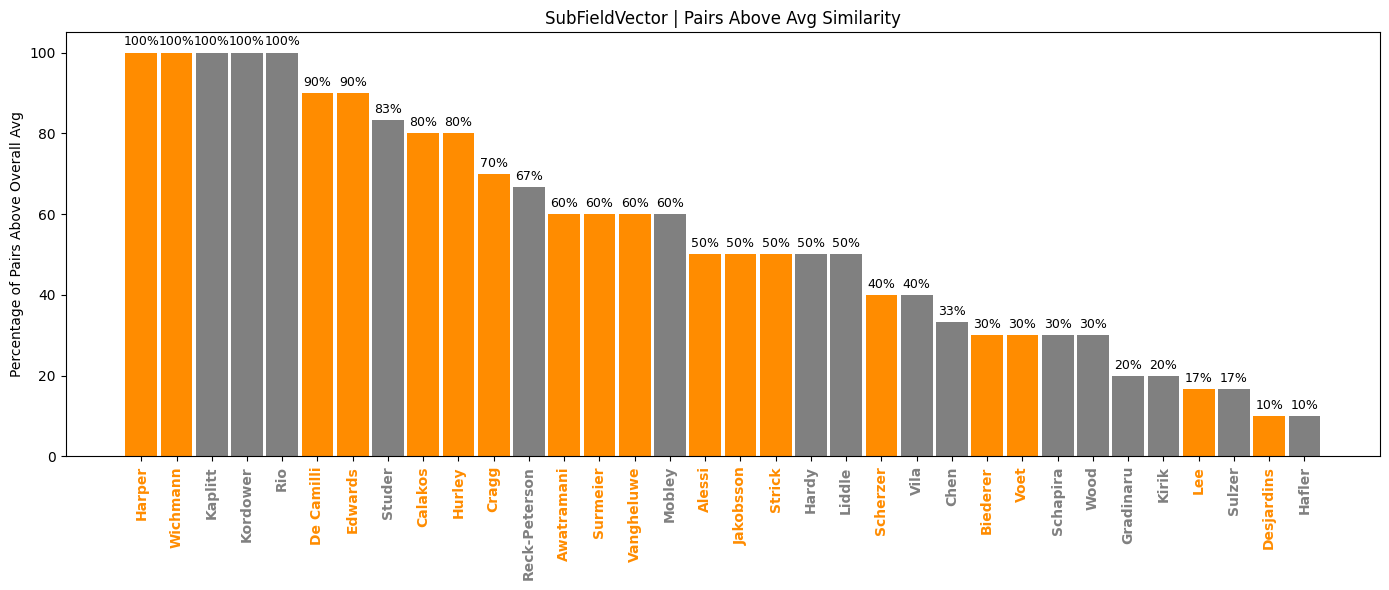

Mean deviation (Yes): 59.2593
Mean deviation (No):  50.6250
Difference: 8.63%
T-test: t=0.851, p=0.4013
Mann–Whitney U: U=169.000, p=0.3955


In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine

def plot_percentage_above_avg(df, supplement_df, vector_col, title_prefix=""):
    # Convert string to numpy arrays if needed
    df[vector_col] = df[vector_col].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)

    # Merge supplement info
    merged = df
    
    # Compute all pairwise sims across teams to get overall average
    all_sims = []
    for team, group in merged.groupby("Team"):
        vecs = list(group[vector_col])
        for i in range(len(vecs)):
            for j in range(i+1, len(vecs)):
                all_sims.append(1 - cosine(vecs[i], vecs[j]))
    overall_avg = np.mean(all_sims)

    # Compute per-team stats
    rows = []
    for team, group in merged.groupby("Team"):
        vecs = list(group[vector_col])
        sims = []
        for i in range(len(vecs)):
            for j in range(i+1, len(vecs)):
                sims.append(1 - cosine(vecs[i], vecs[j]))
        if sims:
            count_above = sum(sim > overall_avg for sim in sims)
            total = len(sims)
            pct = (count_above / total) * 100
            supp = group["Supplement"].iloc[0]
            rows.append((team, pct, count_above, total, supp))

    result_df = pd.DataFrame(rows, columns=["Team", "Percentage", "NumAbove", "TotalPairs", "Supplement"])

    # Sort teams by percentage descending
    result_df = result_df.sort_values(by=["Percentage", "Supplement"], ascending=[False, False]).reset_index(drop=True)

    # Plot
    colors = {"Yes": "darkorange", "No": "gray"}
    plt.figure(figsize=(14, 6))
    bars = plt.bar(result_df["Team"], result_df["Percentage"], 
                   color=result_df["Supplement"].map(colors), width=0.9)

    # Add percentage + fraction on top of bars
    for bar, pct, num, total in zip(bars, result_df["Percentage"], result_df["NumAbove"], result_df["TotalPairs"]):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f"{pct:.0f}%", #f"{pct:.0f}%\n({num}/{total})",
                 ha="center", va="bottom", fontsize=9)

    
    plt.ylabel("Percentage of Pairs Above Overall Avg")
    plt.title(f"{title_prefix} | Pairs Above Avg Similarity")
    # After plotting bars
    plt.xticks(rotation=90, fontweight="bold")

    # Color the labels
    ax = plt.gca()
    for ticklabel, supp in zip(ax.get_xticklabels(), result_df["Supplement"]):
        ticklabel.set_color(colors[supp])

    plt.tight_layout()
    plt.savefig(f"{title_prefix}_percentage_above_avg.png")
    plt.show()

    yes_values = result_df[result_df["Supplement"] == "Yes"]["Percentage"]
    no_values  = result_df[result_df["Supplement"] == "No"]["Percentage"]

    from scipy.stats import ttest_ind, mannwhitneyu

    # Independent samples t-test
    t_stat, t_p = ttest_ind(yes_values, no_values, equal_var=False)

    # Mann–Whitney U test
    u_stat, u_p = mannwhitneyu(yes_values, no_values, alternative="two-sided")

    print(f"Mean deviation (Yes): {yes_values.mean():.4f}")
    print(f"Mean deviation (No):  {no_values.mean():.4f}")
    diff = yes_values.mean() - no_values.mean()
    print("Difference: %.2f%%" % diff)
    print("T-test: t=%.3f, p=%.4f" % (t_stat, t_p))
    print("Mann–Whitney U: U=%.3f, p=%.4f" % (u_stat, u_p))



    return result_df

# Example usage:
topic_above = plot_percentage_above_avg(df, supplement_df, "TopicVector", title_prefix="TopicVector")
subfield_above = plot_percentage_above_avg(df, supplement_df, "SubFieldVector", title_prefix="SubFieldVector")


In [49]:
from scipy.spatial.distance import cosine
from scipy.stats import ttest_ind, mannwhitneyu
import numpy as np

def test_avg_deviation(df, supplement_df, vector_col, title_prefix=""):
    # Convert string to numpy arrays if needed
    df[vector_col] = df[vector_col].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)

    # Merge supplement info
    merged = df 
    # Compute pairwise similarities within each team
    team_pairwise_sims = {}
    for team, group in merged.groupby("Team"):
        vecs = list(group[vector_col])
        sims = []
        for i in range(len(vecs)):
            for j in range(i+1, len(vecs)):
                sims.append(1 - cosine(vecs[i], vecs[j]))
        if sims:
            team_pairwise_sims[team] = np.mean(sims)

    # Overall average similarity
    overall_avg = np.mean([v for v in team_pairwise_sims.values()])

    # Deviations (not absolute)
    team_devs = {team: avg - overall_avg for team, avg in team_pairwise_sims.items()}

    # Attach supplement labels
    team_dev_df = (pd.DataFrame(list(team_devs.items()), columns=["Team", "Deviation"])
                     .merge(supplement_df, on="Team", how="left"))

    yes_vals = team_dev_df[team_dev_df["Supplement"] == "Yes"]["Deviation"]
    no_vals = team_dev_df[team_dev_df["Supplement"] == "No"]["Deviation"]

    # Run tests
    t_stat, t_p = ttest_ind(yes_vals, no_vals, equal_var=False)
    u_stat, u_p = mannwhitneyu(yes_vals, no_vals, alternative="two-sided")

    print(f"=== {title_prefix} ===")
    print(f"Overall average similarity: {overall_avg:.4f}")
    print(f"Mean deviation (Yes): {yes_vals.mean():.4f}")
    print(f"Mean deviation (No):  {no_vals.mean():.4f}")
    print(f"T-test: t={t_stat:.3f}, p={t_p:.4f}")
    print(f"Mann–Whitney U: U={u_stat:.3f}, p={u_p:.4f}\n")

    return team_dev_df

# Example usage:
topic_results = test_avg_deviation(df, supplement_df, "TopicVector", title_prefix="TopicVector Deviations")
subfield_results = test_avg_deviation(df, supplement_df, "SubFieldVector", title_prefix="SubFieldVector Deviations")


=== TopicVector Deviations ===
Overall average similarity: 0.3542
Mean deviation (Yes): 0.0274
Mean deviation (No):  -0.0308
T-test: t=1.030, p=0.3108
Mann–Whitney U: U=164.000, p=0.5011

=== SubFieldVector Deviations ===
Overall average similarity: 0.6550
Mean deviation (Yes): 0.0286
Mean deviation (No):  -0.0322
T-test: t=1.150, p=0.2601
Mann–Whitney U: U=174.000, p=0.3088



In [50]:
pi_df = pd.read_csv('pub_tracker_all_pis_with_reference_info.csv')

In [ ]:
import pandas as pd
from collections import Counter

# Assume you have a function to fetch topics/subfields from OpenAlex
def fetch_topics_and_subfields(work_id):
    # Example structure: replace with actual OpenAlex API call
    work_data = Works()[work_id]  # pseudo-code
    topics = []
    subfields = []
    for t in work_data.get("topic", []):
        topic_id = t["id"].replace("https://openalex.org/", "")
        subfield_id = t["subfield"]["id"]
        topics.append(topic_id)
        subfields.append(subfield_id)
    return topics, subfields

# Step 1: add ListOfTopics and ListOfSubfields to pi_df
pi_df["ListOfTopics"] = pi_df["OpenAlex_ID"].apply(lambda wid: fetch_topics_and_subfields(wid)[0])
pi_df["ListOfSubfields"] = pi_df["OpenAlex_ID"].apply(lambda wid: fetch_topics_and_subfields(wid)[1])

# Step 2: aggregate at the Team level (avoid double counting per work within team)
def aggregate_team_topics(df):
    # group by OpenAlex_ID within a team, keep only one set of topics per work
    unique_works = df.drop_duplicates(subset=["Team", "OpenAlex_ID"])
    topics = sum(unique_works["ListOfTopics"], [])  # flatten
    subfields = sum(unique_works["ListOfSubfields"], [])
    return pd.Series({"AllTopics": topics, "AllSubfields": subfields})

team_df = pi_df.groupby("Team").apply(aggregate_team_topics).reset_index()

# Step 3: make vector counts
team_df["TopicVector"] = team_df["AllTopics"].apply(lambda x: dict(Counter(x)))
team_df["SubfieldVector"] = team_df["AllSubfields"].apply(lambda x: dict(Counter(x)))



ValueError: record_id should be a string or a list of strings

In [54]:
from pyalex import Works
import pandas as pd

# --- Helper function to fetch topics and subfields for one work ---
def fetch_topics_and_subfields(work_id):
    """
    Given an OpenAlex Work ID (string like 'W123456789'),
    return (topics, subfields).
    """
    try:
        work_data = Works()[work_id]  # fetch work from OpenAlex
        topics = [t["display_name"] for t in work_data.get("topics", [])]
        subfields = [s["display_name"] for s in work_data.get("concepts", []) if s.get("level") == 2]
        return topics, subfields
    except Exception as e:
        print(f"Error fetching {work_id}: {e}")
        return [], []

# --- Step 1: Add ListOfTopics and ListOfSubfields to pi_df ---
# Make sure OpenAlex_ID looks like "W123456789"
pi_df["OpenAlex_ID"] = pi_df["OpenAlex_ID"].astype(str)
pi_df["OpenAlex_ID"] = pi_df["OpenAlex_ID"].apply(lambda x: x if x.startswith("W") else f"W{x}")

pi_df["ListOfTopics"], pi_df["ListOfSubfields"] = zip(*pi_df["OpenAlex_ID"].apply(fetch_topics_and_subfields))

# --- Step 2: aggregate at the Team level (avoid double counting per work within team) ---
team_agg = (
    pi_df.groupby("Team")
    .agg({
        "ListOfTopics": lambda x: list({t for sublist in x for t in sublist}),
        "ListOfSubfields": lambda x: list({s for sublist in x for s in sublist}),
    })
    .reset_index()
)

team_agg.head()


Error fetching Wnan: 404 Client Error: NOT FOUND for url: https://api.openalex.org/works/Wnan
Error fetching Wnan: 404 Client Error: NOT FOUND for url: https://api.openalex.org/works/Wnan
Error fetching Wnan: 404 Client Error: NOT FOUND for url: https://api.openalex.org/works/Wnan
Error fetching Wnan: 404 Client Error: NOT FOUND for url: https://api.openalex.org/works/Wnan
Error fetching Wnan: 404 Client Error: NOT FOUND for url: https://api.openalex.org/works/Wnan
Error fetching Wnan: 404 Client Error: NOT FOUND for url: https://api.openalex.org/works/Wnan
Error fetching Wnan: 404 Client Error: NOT FOUND for url: https://api.openalex.org/works/Wnan
Error fetching Wnan: 404 Client Error: NOT FOUND for url: https://api.openalex.org/works/Wnan
Error fetching Wnan: 404 Client Error: NOT FOUND for url: https://api.openalex.org/works/Wnan
Error fetching Wnan: 404 Client Error: NOT FOUND for url: https://api.openalex.org/works/Wnan
Error fetching Wnan: 404 Client Error: NOT FOUND for url: ht

,Team,ListOfTopics,ListOfSubfields
0,Team Alessi,"[Pluripotent Stem Cells Research, Neuroscience...","[Effector, Metabolic network, Mechanism (biolo..."
1,Team Awatramani,"[Neuroscience and Neural Engineering, Neurolog...","[Nucleus, Signal transduction, Cell, Gene, Mov..."
2,Team Biederer,"[Neuroscience and Neural Engineering, Neurolog...","[Rendering (computer graphics), Cluster (space..."
3,Team Calakos,"[Neuroscience and Neural Engineering, Memory a...","[Cell, Central nervous system, Function (biolo..."
4,Team Chen,"[Biochemical Analysis and Sensing Techniques, ...","[Cancer, Melanin, Confidence interval, Statin,..."


In [55]:
def aggregate_team_topics(df):
    # group by OpenAlex_ID within a team, keep only one set of topics per work
    unique_works = df.drop_duplicates(subset=["Team", "OpenAlex_ID"])
    topics = sum(unique_works["ListOfTopics"], [])  # flatten
    subfields = sum(unique_works["ListOfSubfields"], [])
    return pd.Series({"AllTopics": topics, "AllSubfields": subfields})

team_df = pi_df.groupby("Team").apply(aggregate_team_topics).reset_index()

# Step 3: make vector counts
team_df["TopicVector"] = team_df["AllTopics"].apply(lambda x: dict(Counter(x)))
team_df["SubfieldVector"] = team_df["AllSubfields"].apply(lambda x: dict(Counter(x)))

C:\Users\school\AppData\Local\Temp\ipykernel_49084\2204045856.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  team_df = pi_df.groupby("Team").apply(aggregate_team_topics).reset_index()


In [ ]:
team_df.to_csv('within_network_vectors.csv')


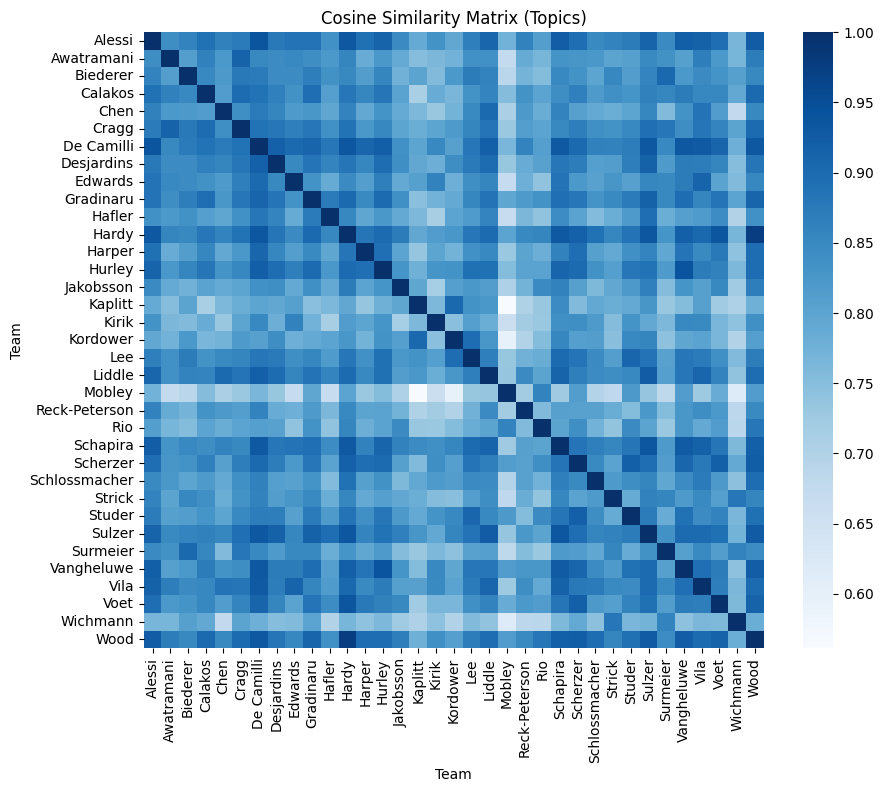

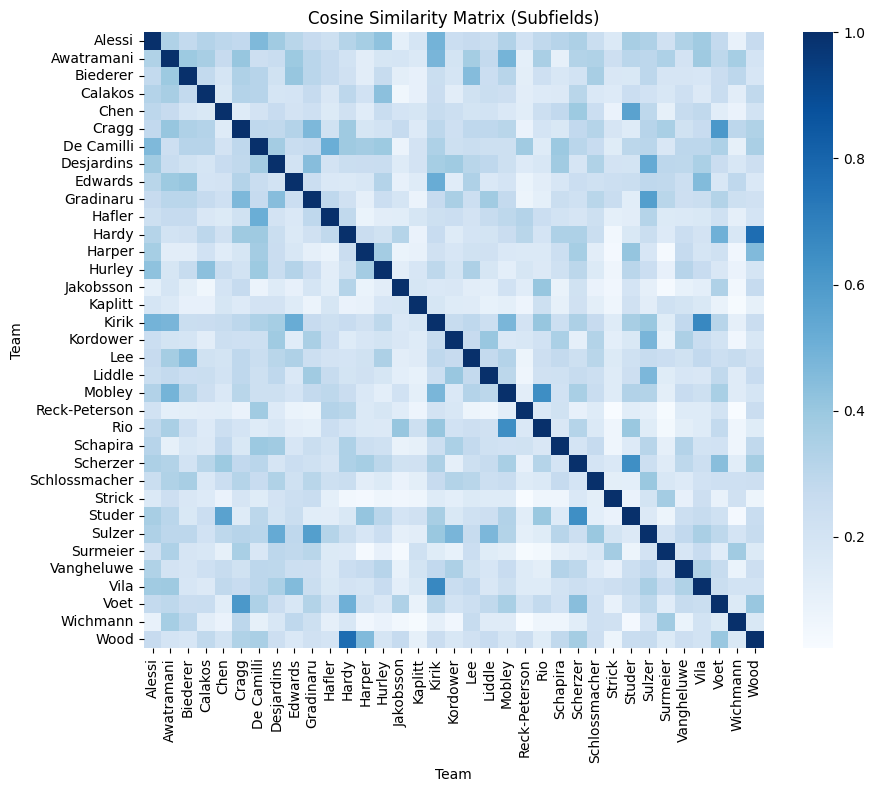

ValueError: cannot insert Team, already exists

In [61]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# --- Clean Team column in pi_df ---
pi_df["Team"] = pi_df["Team"].str.replace("Team ", "", regex=False)
pi_df = pi_df[pi_df["Team"] != "MAC"]

# --- Aggregate lists per team (dedupe within team) ---
team_lists = (
    pi_df.groupby("Team")
    .agg({
        "ListOfTopics": lambda x: list({t for sublist in x for t in sublist}),
        "ListOfSubfields": lambda x: list({s for sublist in x for s in sublist}),
    })
    .reset_index()
)

# --- Helper to convert lists into bag-of-words vectors ---
def build_cosine_matrix(lists, label):
    # Convert each list to a "document"
    docs = [" ".join(lst) for lst in lists]
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(docs)
    
    # Cosine similarity
    cos_sim = cosine_similarity(X)
    cos_df = pd.DataFrame(cos_sim, index=team_lists["Team"], columns=team_lists["Team"])
    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cos_df, annot=False, cmap="Blues", xticklabels=True, yticklabels=True)
    plt.title(f"Cosine Similarity Matrix ({label})")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()
    
    return cos_df

# --- Build cosine similarity matrices ---
topic_cos_df = build_cosine_matrix(team_lists["ListOfTopics"], "Topics")
subfield_cos_df = build_cosine_matrix(team_lists["ListOfSubfields"], "Subfields")

# --- Merge with supplement_df for group info ---
#supplement_df["Team"] = supplement_df["Team"].str.replace("Team ", "", regex=False)
#merged = supplement_df.merge(team_lists, on="Team", how="inner")

# --- Convert cosine matrices to long-form for testing ---
def melt_cos_df(cos_df, name):
    df_long = cos_df.stack().reset_index()
    df_long.columns = ["Team1", "Team2", "CosSim"]
    df_long = df_long[df_long["Team1"] < df_long["Team2"]]  # drop self-pairs and duplicates
    df_long["Measure"] = name
    return df_long

topic_long = melt_cos_df(topic_cos_df, "Topic")
subfield_long = melt_cos_df(subfield_cos_df, "Subfield")

# --- Attach supplement group info ---
supp_map = dict(zip(supplement_df["Team"], supplement_df["Supplement"]))
for df in [topic_long, subfield_long]:
    df["Supp_T1"] = df["Team1"].map(supp_map)
    df["Supp_T2"] = df["Team2"].map(supp_map)
    # Label whether both teams are Yes, both No, or Mixed
    df["Supp_Group"] = np.where(df["Supp_T1"] == df["Supp_T2"], df["Supp_T1"], "Mixed")

# --- Run test: Compare cosine similarities across supplement groups ---
from scipy.stats import ttest_ind

def compare_groups(df, label):
    yes_vals = df.loc[df["Supp_Group"] == "Yes", "CosSim"]
    no_vals = df.loc[df["Supp_Group"] == "No", "CosSim"]
    mixed_vals = df.loc[df["Supp_Group"] == "Mixed", "CosSim"]
    
    print(f"\n=== {label} Cosine Similarity Tests ===")
    print(f"Mean Yes: {yes_vals.mean():.3f}, Mean No: {no_vals.mean():.3f}, Mean Mixed: {mixed_vals.mean():.3f}")
    print("t-test Yes vs No:", ttest_ind(yes_vals, no_vals, equal_var=False))
    print("t-test Yes vs Mixed:", ttest_ind(yes_vals, mixed_vals, equal_var=False))
    print("t-test No vs Mixed:", ttest_ind(no_vals, mixed_vals, equal_var=False))

compare_groups(topic_long, "Topic")
compare_groups(subfield_long, "Subfield")


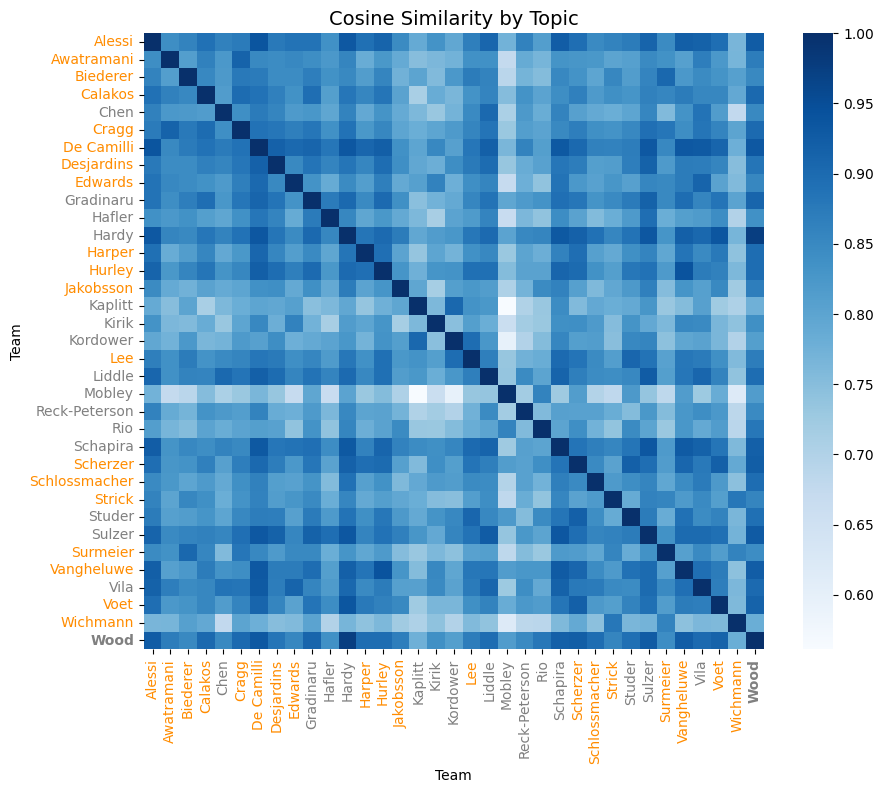

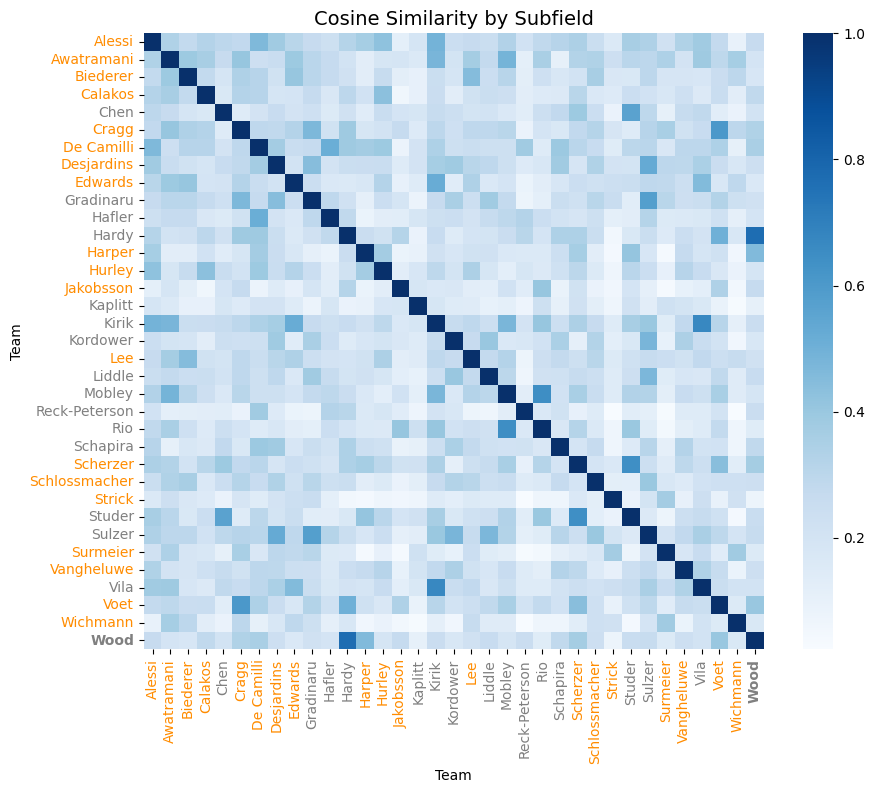

Topic test: TtestResult(statistic=np.float64(1.4018605680794016), pvalue=np.float64(0.16148010435742452), df=np.float64(592.9832706036132))
Subfield test: TtestResult(statistic=np.float64(1.911256589865895), pvalue=np.float64(0.0564613441207833), df=np.float64(583.3886097777895))


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine
from scipy.stats import ttest_ind

# --- helper: cosine similarity ---
def cosine_similarity(vec1, vec2):
    if np.linalg.norm(vec1) == 0 or np.linalg.norm(vec2) == 0:
        return 0
    return 1 - cosine(vec1, vec2)

# --- build cosine similarity matrix ---
def build_cosine_matrix(team_vectors, measure_name):
    teams = list(team_vectors.keys())
    cos_matrix = pd.DataFrame(index=teams, columns=teams, dtype=float)
    for t1 in teams:
        for t2 in teams:
            cos_matrix.loc[t1, t2] = cosine_similarity(team_vectors[t1], team_vectors[t2])
    return cos_matrix

# --- melt function (fixing the error) ---
def melt_cos_df(cos_df, name):
    # Reset index so row index (teams) is a column
    df_long = cos_df.reset_index().melt(id_vars="Team", var_name="Team2", value_name="CosSim")
    
    # Rename "Team" to Team1
    df_long = df_long.rename(columns={"Team": "Team1"})
    
    # Drop self-comparisons and keep unique pairs (Team1 < Team2 ensures uniqueness)
    df_long = df_long[df_long["Team1"] < df_long["Team2"]]
    
    # Add measure type (Topic or Subfield)
    df_long["Measure"] = name
    
    return df_long


# Example: topic_cos_df, subfield_cos_df
topic_long = melt_cos_df(topic_cos_df, "Topic")
subfield_long = melt_cos_df(subfield_cos_df, "Subfield")

# --- attach supplement info ---
supplement_df["Team"] = supplement_df["Team"].str.replace("Team ", "", regex=False)
topic_long = topic_long.merge(supplement_df, left_on="Team1", right_on="Team", how="left").drop(columns="Team").rename(columns={"Supplement": "Supp1"})
topic_long = topic_long.merge(supplement_df, left_on="Team2", right_on="Team", how="left").drop(columns="Team").rename(columns={"Supplement": "Supp2"})

subfield_long = subfield_long.merge(supplement_df, left_on="Team1", right_on="Team", how="left").drop(columns="Team").rename(columns={"Supplement": "Supp1"})
subfield_long = subfield_long.merge(supplement_df, left_on="Team2", right_on="Team", how="left").drop(columns="Team").rename(columns={"Supplement": "Supp2"})

# --- plot heatmap with colored labels ---
def plot_heatmap(cos_df, title, supplement_df):
    teams = cos_df.index.tolist()
    # color map for labels
    supp_map = dict(zip(supplement_df["Team"], supplement_df["Supplement"]))
    label_colors = ["darkorange" if supp_map[t] == "Yes" else "grey" for t in teams]

    plt.figure(figsize=(10,8))
    ax = sns.heatmap(cos_df.astype(float), cmap="Blues", xticklabels=teams, yticklabels=teams, cbar=True)
    ax.set_title(title, fontsize=14)

    # apply color to x and y tick labels
    for xtick, color in zip(ax.get_xticklabels(), label_colors):
        xtick.set_color(color)
        xtick.set_fontweight("bold")
    for ytick, color in zip(ax.get_yticklabels(), label_colors):
        ytick.set_color(color)
        ytick.set_fontweight("bold")
    
    
    plt.show()

plot_heatmap(topic_cos_df, "Cosine Similarity by Topic", supplement_df)
plot_heatmap(subfield_cos_df, "Cosine Similarity by Subfield", supplement_df)

# --- test differences by supplement value ---
def test_diff(df_long):
    # average cosine similarity per pair grouped by supplement grouping
    df_long["Group"] = df_long["Supp1"] + "-" + df_long["Supp2"]
    same_supp = df_long[df_long["Supp1"] == df_long["Supp2"]]["CosSim"]
    diff_supp = df_long[df_long["Supp1"] != df_long["Supp2"]]["CosSim"]
    return ttest_ind(same_supp, diff_supp, equal_var=False)

print("Topic test:", test_diff(topic_long))
print("Subfield test:", test_diff(subfield_long))


In [19]:
from scipy.stats import ttest_ind, mannwhitneyu
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import ast
from scipy.stats import f_oneway, kruskal

# -----------------------------
# Step 1: Fix vector columns
# -----------------------------
def parse_vector(x):
    if isinstance(x, str):
        try:
            return np.array(ast.literal_eval(x), dtype=float)
        except:
            return np.nan
    return x

df["SubFieldVector"] = df["SubFieldVector"].apply(parse_vector)
df["TopicVector"] = df["TopicVector"].apply(parse_vector)

# Drop any rows where parsing failed
df = df.dropna(subset=["SubFieldVector", "TopicVector"])

# -----------------------------
# Step 2: Compute mean pairwise cosine similarity per team
# -----------------------------
def mean_pairwise_cosine(vectors):
    if len(vectors) < 2:
        return np.nan
    sims = cosine_similarity(np.vstack(vectors))
    # take upper triangle without diagonal
    triu_vals = sims[np.triu_indices_from(sims, k=1)]
    return np.mean(triu_vals)

team_means = df.groupby("Team").agg(
    Mean_Subfield_Cosine=("SubFieldVector", mean_pairwise_cosine),
    Mean_Topic_Cosine=("TopicVector", mean_pairwise_cosine)
).reset_index()

# -----------------------------
# Step 3: Merge with wave_df
# -----------------------------
merged_df = pd.merge(team_means, wave_df, on="Team", how="inner")

# Split into two groups by Round
rounds = merged_df["Round"].unique()
if len(rounds) != 2:
    raise ValueError("This test is only appropriate if there are exactly 2 categories in Round")

round1 = merged_df.loc[merged_df["Round"] == rounds[0]]
round2 = merged_df.loc[merged_df["Round"] == rounds[1]]

# Topic cosine similarity
t_topic, p_topic = ttest_ind(round1["Mean_Topic_Cosine"].dropna(),
                             round2["Mean_Topic_Cosine"].dropna(),
                             equal_var=False)  # Welch's t-test is safer
u_topic, up_topic = mannwhitneyu(round1["Mean_Topic_Cosine"].dropna(),
                                 round2["Mean_Topic_Cosine"].dropna(),
                                 alternative="two-sided")

# Subfield cosine similarity
t_sub, p_sub = ttest_ind(round1["Mean_Subfield_Cosine"].dropna(),
                         round2["Mean_Subfield_Cosine"].dropna(),
                         equal_var=False)
u_sub, up_sub = mannwhitneyu(round1["Mean_Subfield_Cosine"].dropna(),
                             round2["Mean_Subfield_Cosine"].dropna(),
                             alternative="two-sided")

print(f"=== Topic Cosine Similarity ===")
print(f"T-test: t={t_topic:.3f}, p={p_topic:.4f}")
print(f"Mann–Whitney U: U={u_topic:.3f}, p={up_topic:.4f}\n")

print(f"=== Subfield Cosine Similarity ===")
print(f"T-test: t={t_sub:.3f}, p={p_sub:.4f}")
print(f"Mann–Whitney U: U={u_sub:.3f}, p={up_sub:.4f}")


=== Topic Cosine Similarity ===
T-test: t=-1.528, p=0.1390
Mann–Whitney U: U=92.000, p=0.0665

=== Subfield Cosine Similarity ===
T-test: t=-0.911, p=0.3691
Mann–Whitney U: U=125.000, p=0.4691


In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import ast
from scipy.stats import f_oneway, kruskal

# -----------------------------
# Step 1: Fix vector columns
# -----------------------------
def parse_vector(x):
    if isinstance(x, str):
        try:
            return np.array(ast.literal_eval(x), dtype=float)
        except:
            return np.nan
    return x

df["SubFieldVector"] = df["SubFieldVector"].apply(parse_vector)
df["TopicVector"] = df["TopicVector"].apply(parse_vector)

# Drop any rows where parsing failed
df = df.dropna(subset=["SubFieldVector", "TopicVector"])

# -----------------------------
# Step 2: Compute mean pairwise cosine similarity per team
# -----------------------------
def mean_pairwise_cosine(vectors):
    if len(vectors) < 2:
        return np.nan
    sims = cosine_similarity(np.vstack(vectors))
    # take upper triangle without diagonal
    triu_vals = sims[np.triu_indices_from(sims, k=1)]
    return np.mean(triu_vals)

team_means = df.groupby("Team").agg(
    Mean_Subfield_Cosine=("SubFieldVector", mean_pairwise_cosine),
    Mean_Topic_Cosine=("TopicVector", mean_pairwise_cosine)
).reset_index()

# -----------------------------
# Step 3: Merge with accept_df
# -----------------------------
merged_df = pd.merge(team_means, accept_df, on="Team", how="inner")

# -----------------------------
# Step 4: Statistical tests
# -----------------------------
# Collect values per round
topic_groups = [group["Mean_Topic_Cosine"].dropna().values for _, group in merged_df.groupby("Renewal")]
subfield_groups = [group["Mean_Subfield_Cosine"].dropna().values for _, group in merged_df.groupby("Renewal")]

# ANOVA (parametric)
f_topic, p_topic = f_oneway(*topic_groups)
f_subfield, p_subfield = f_oneway(*subfield_groups)

# Kruskal-Wallis (non-parametric, robust to non-normal distributions)
k_topic, kp_topic = kruskal(*topic_groups)
k_subfield, kp_subfield = kruskal(*subfield_groups)

print("=== Topic Cosine Similarity ===")
print(f"ANOVA: F={f_topic:.3f}, p={p_topic:.4f}")
print(f"Kruskal-Wallis: H={k_topic:.3f}, p={kp_topic:.4f}\n")

print("=== Subfield Cosine Similarity ===")
print(f"ANOVA: F={f_subfield:.3f}, p={p_subfield:.4f}")
print(f"Kruskal-Wallis: H={k_subfield:.3f}, p={kp_subfield:.4f}")


=== Topic Cosine Similarity ===
ANOVA: F=1.727, p=0.1945
Kruskal-Wallis: H=1.838, p=0.3990

=== Subfield Cosine Similarity ===
ANOVA: F=2.459, p=0.1021
Kruskal-Wallis: H=4.413, p=0.1101


In [23]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import ttest_ind, mannwhitneyu

# --- Step 1: Merge supplement info ---
merged = df
# --- Step 2: Convert vectors from string to list ---
def parse_vector(v):
    if isinstance(v, str):
        return np.array(eval(v))  # convert string to list of floats
    return np.array(v)

merged['TopicVector'] = merged['TopicVector'].apply(parse_vector)
merged['SubFieldVector'] = merged['SubFieldVector'].apply(parse_vector)

# --- Helper: compute mean cosine similarity between teams ---
def mean_team_similarities(df, vector_col):
    teams = df['Team'].unique()
    sim_records = []
    for i, team1 in enumerate(teams):
        vecs1 = np.stack(df.loc[df['Team'] == team1, vector_col])
        avg_vec1 = vecs1.mean(axis=0)

        for j, team2 in enumerate(teams):
            if j <= i: 
                continue  # avoid duplicates & self
            vecs2 = np.stack(df.loc[df['Team'] == team2, vector_col])
            avg_vec2 = vecs2.mean(axis=0)

            sim = cosine_similarity([avg_vec1], [avg_vec2])[0][0]
            supp1 = df.loc[df['Team'] == team1, 'Supplement'].iloc[0]
            supp2 = df.loc[df['Team'] == team2, 'Supplement'].iloc[0]

            sim_records.append({
                'Team1': team1, 'Team2': team2,
                'Supplement1': supp1, 'Supplement2': supp2,
                'Similarity': sim
            })
    return pd.DataFrame(sim_records)

# --- Helper: compute similarity using summed vectors ---
def summed_team_similarities(df, vector_col):
    teams = df['Team'].unique()
    team_vecs = {}
    for team in teams:
        vecs = np.stack(df.loc[df['Team'] == team, vector_col])
        summed_vec = vecs.sum(axis=0)
        team_vecs[team] = summed_vec

    sim_records = []
    for i, team1 in enumerate(teams):
        for j, team2 in enumerate(teams):
            if j <= i:
                continue
            sim = cosine_similarity([team_vecs[team1]], [team_vecs[team2]])[0][0]
            supp1 = df.loc[df['Team'] == team1, 'Supplement'].iloc[0]
            supp2 = df.loc[df['Team'] == team2, 'Supplement'].iloc[0]

            sim_records.append({
                'Team1': team1, 'Team2': team2,
                'Supplement1': supp1, 'Supplement2': supp2,
                'Similarity': sim
            })
    return pd.DataFrame(sim_records)

# --- Step 3: Run for both methods and both vector types ---
results = {}

for method_name, func in {
    'Average': mean_team_similarities,
    'Summed': summed_team_similarities
}.items():
    for vec_type in ['TopicVector', 'SubFieldVector']:
        sims = func(merged, vec_type)

        same_group = sims[sims['Supplement1'] == sims['Supplement2']]['Similarity']
        diff_group = sims[sims['Supplement1'] != sims['Supplement2']]['Similarity']

        # t-test (Welch’s)
        t_stat, t_p = ttest_ind(same_group, diff_group, equal_var=False)

        # Mann-Whitney U
        u_stat, u_p = mannwhitneyu(same_group, diff_group, alternative='two-sided')

        results[(method_name, vec_type)] = {
            't-test': (t_stat, t_p),
            'Mann–Whitney U': (u_stat, u_p)
        }

# --- Step 4: Print results ---
for (method, vec), stats in results.items():
    print(f"\n=== {method} Method | {vec} ===")
    print(f"T-test: t={stats['t-test'][0]:.3f}, p={stats['t-test'][1]:.4f}")
    print(f"Mann–Whitney U: U={stats['Mann–Whitney U'][0]:.3f}, p={stats['Mann–Whitney U'][1]:.4f}")



=== Average Method | TopicVector ===
T-test: t=2.387, p=0.0173
Mann–Whitney U: U=48516.000, p=0.0410

=== Average Method | SubFieldVector ===
T-test: t=0.483, p=0.6290
Mann–Whitney U: U=45629.000, p=0.5053

=== Summed Method | TopicVector ===
T-test: t=2.387, p=0.0173
Mann–Whitney U: U=48516.000, p=0.0410

=== Summed Method | SubFieldVector ===
T-test: t=0.483, p=0.6290
Mann–Whitney U: U=45629.000, p=0.5053


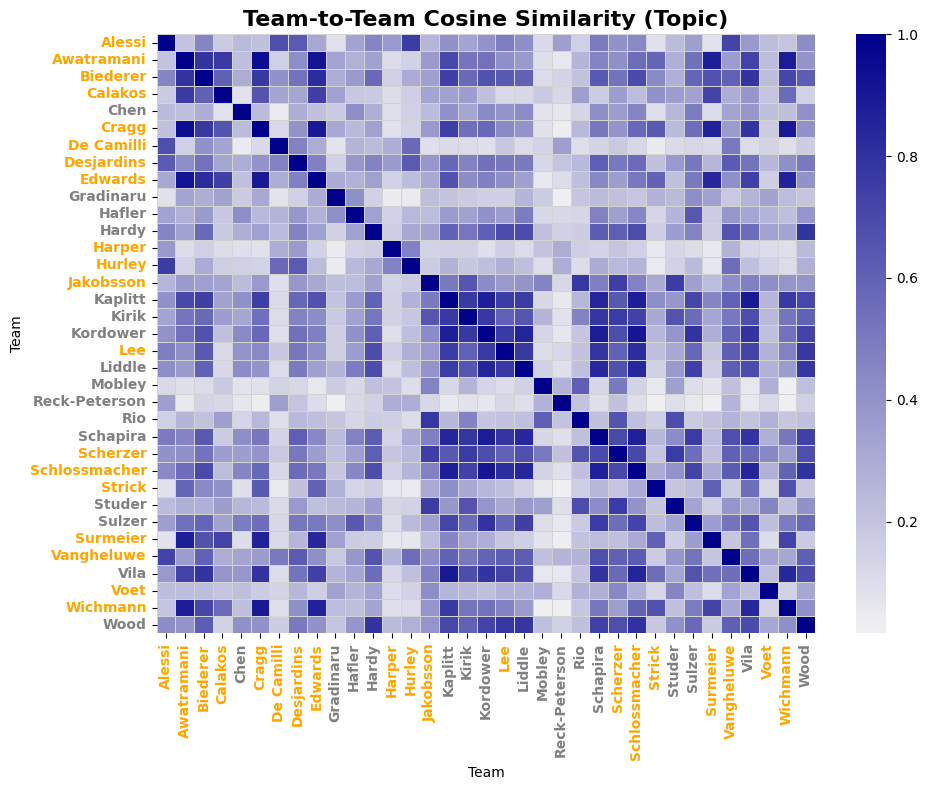

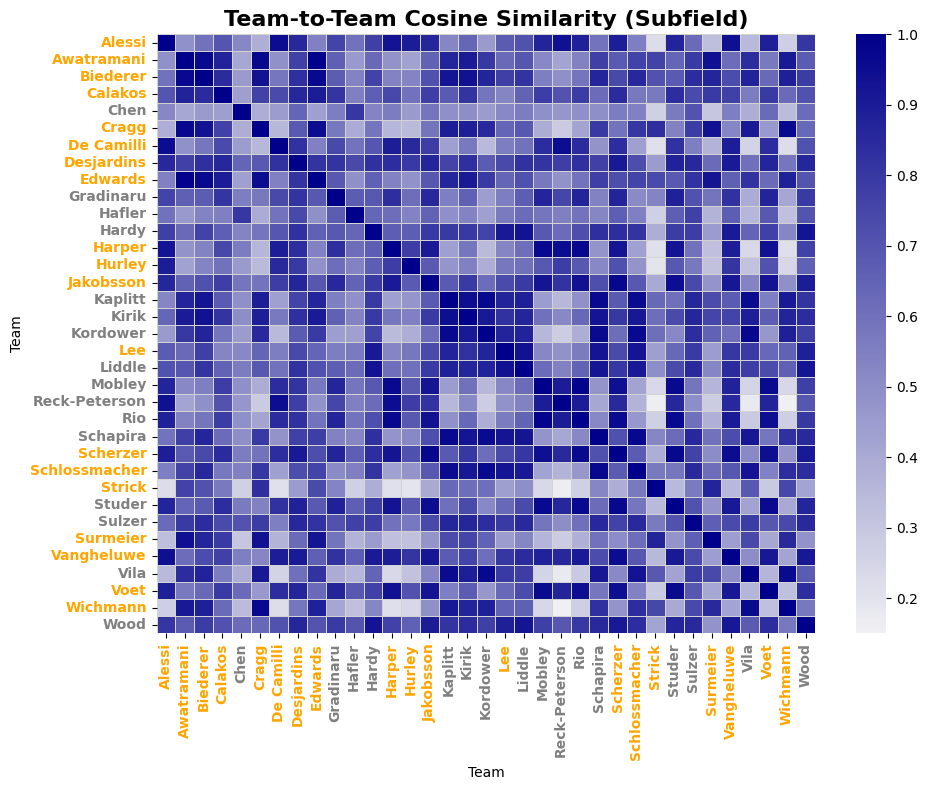

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# --- Step 1: Convert vector strings back to lists ---
def parse_vector(x):
    if isinstance(x, str):
        return np.array(eval(x))  # safely convert "[0.1, 0.2]" → np.array
    elif isinstance(x, list) or isinstance(x, np.ndarray):
        return np.array(x)
    else:
        return np.nan

df['TopicVector'] = df['TopicVector'].apply(parse_vector)
df['SubFieldVector'] = df['SubFieldVector'].apply(parse_vector)

# --- Step 2: Aggregate to team-level vectors (summing or averaging works the same) ---
team_vectors = df.groupby('Team').agg({
    'TopicVector': lambda x: np.sum(np.stack(x), axis=0),
    'SubFieldVector': lambda x: np.sum(np.stack(x), axis=0),
    'Supplement': 'first'  # keep supplement value per team
}).reset_index()

# --- Step 3: Compute cosine similarity matrices ---
topic_sim = cosine_similarity(list(team_vectors['TopicVector']))
subfield_sim = cosine_similarity(list(team_vectors['SubFieldVector']))

# Put into DataFrames for labeling
topic_df = pd.DataFrame(topic_sim, index=team_vectors['Team'], columns=team_vectors['Team'])
subfield_df = pd.DataFrame(subfield_sim, index=team_vectors['Team'], columns=team_vectors['Team'])

# --- Step 4: Color code team labels by supplement ---
supp_colors = team_vectors['Supplement'].map({'Yes': 'orange', 'No': 'grey'})
row_colors = supp_colors.values

# --- Step 5: Plot heatmaps ---
def plot_heatmap(matrix_df, title, row_colors):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_df, cmap=sns.light_palette("darkblue", as_cmap=True), 
                cbar=True, linewidths=0.5, linecolor='lightgrey')
    
    # Color-coded team names
    ax = plt.gca()
    for tick_label, color in zip(ax.get_xticklabels(), row_colors):
        tick_label.set_color(color)
        tick_label.set_fontweight("bold")
    for tick_label, color in zip(ax.get_yticklabels(), row_colors):
        tick_label.set_color(color)
        tick_label.set_fontweight("bold")
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Topic similarity heatmap
plot_heatmap(topic_df, "Team-to-Team Cosine Similarity (Topic)", row_colors)

# Subfield similarity heatmap
plot_heatmap(subfield_df, "Team-to-Team Cosine Similarity (Subfield)", row_colors)


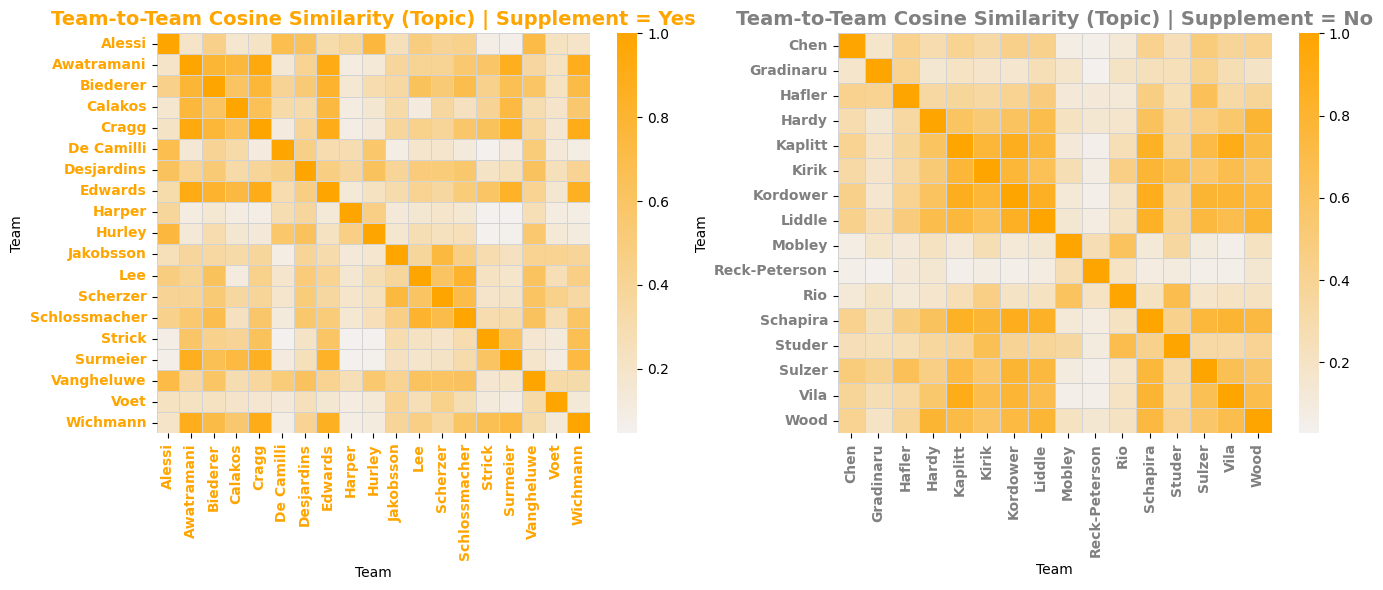

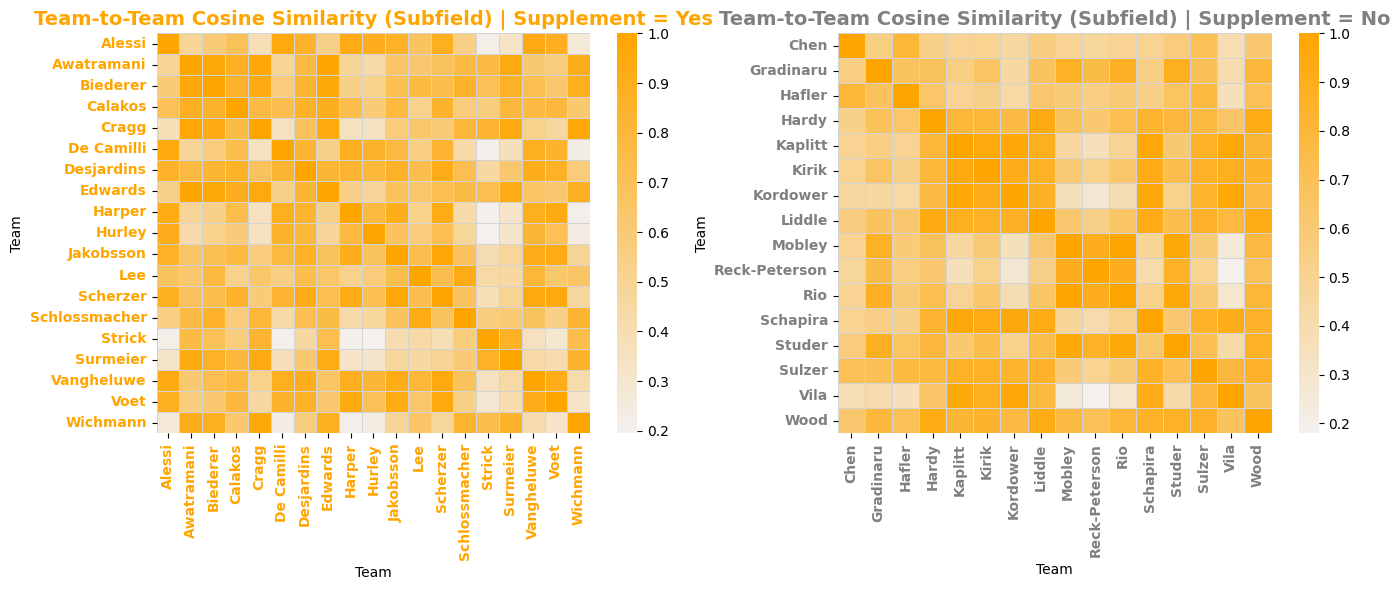

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# --- Parse vectors if needed ---
def parse_vector(x):
    if isinstance(x, str):
        return np.array(eval(x))
    elif isinstance(x, list) or isinstance(x, np.ndarray):
        return np.array(x)
    else:
        return np.nan

df['TopicVector'] = df['TopicVector'].apply(parse_vector)
df['SubFieldVector'] = df['SubFieldVector'].apply(parse_vector)

# --- Aggregate to team level ---
team_vectors = df.groupby('Team').agg({
    'TopicVector': lambda x: np.sum(np.stack(x), axis=0),
    'SubFieldVector': lambda x: np.sum(np.stack(x), axis=0),
    'Supplement': 'first'
}).reset_index()

# --- Compute similarity matrices ---
topic_sim = cosine_similarity(list(team_vectors['TopicVector']))
subfield_sim = cosine_similarity(list(team_vectors['SubFieldVector']))

topic_df = pd.DataFrame(topic_sim, index=team_vectors['Team'], columns=team_vectors['Team'])
subfield_df = pd.DataFrame(subfield_sim, index=team_vectors['Team'], columns=team_vectors['Team'])

# --- Helper to plot split matrices ---
def plot_split_heatmaps(matrix_df, vectors_df, vector_name):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    for ax, group, color in zip(
        axes, ["Yes", "No"], ["orange", "grey"]
    ):
        # Select only teams in this supplement group
        teams = vectors_df.loc[vectors_df['Supplement'] == group, 'Team']
        sub_matrix = matrix_df.loc[teams, teams]

        # Plot heatmap
        sns.heatmap(sub_matrix, cmap=sns.light_palette("orange", as_cmap=True),
                    cbar=True, linewidths=0.5, linecolor='lightgrey',
                    ax=ax)
        
        # Color tick labels
        for tick_label in ax.get_xticklabels():
            tick_label.set_color(color)
            tick_label.set_fontweight("bold")
        for tick_label in ax.get_yticklabels():
            tick_label.set_color(color)
            tick_label.set_fontweight("bold")
        
        ax.set_title(f"{vector_name} | Supplement = {group}", 
                     fontsize=14, fontweight="bold", color=color)

    plt.tight_layout()
    plt.show()

# --- Plot for Topic ---
plot_split_heatmaps(topic_df, team_vectors, "Team-to-Team Cosine Similarity (Topic)")

# --- Plot for Subfield ---
plot_split_heatmaps(subfield_df, team_vectors, "Team-to-Team Cosine Similarity (Subfield)")


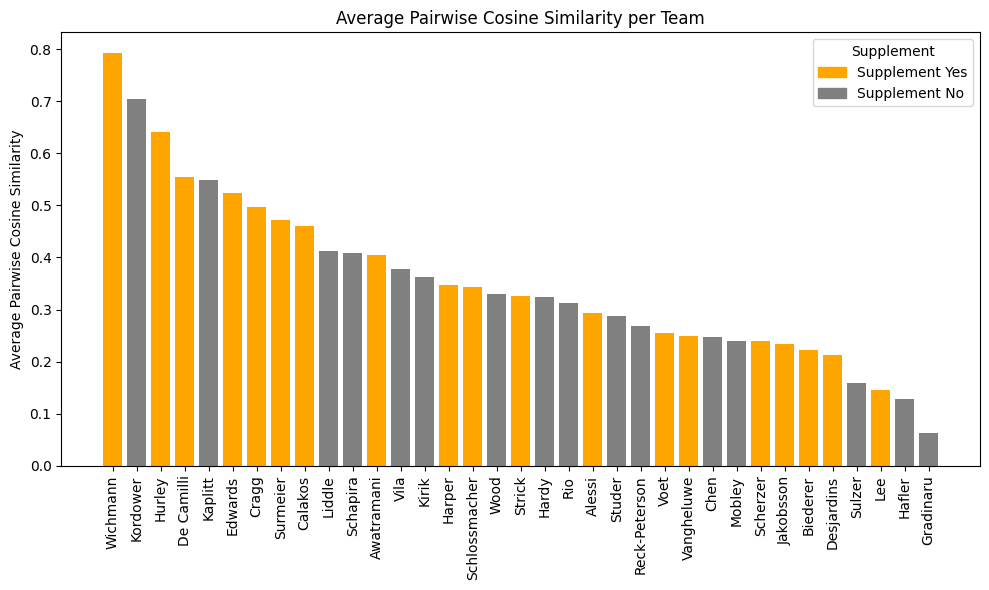

C:\Users\school\AppData\Local\Temp\ipykernel_10264\2307373302.py:82: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(box_data, patch_artist=True, labels=box_order_overall)


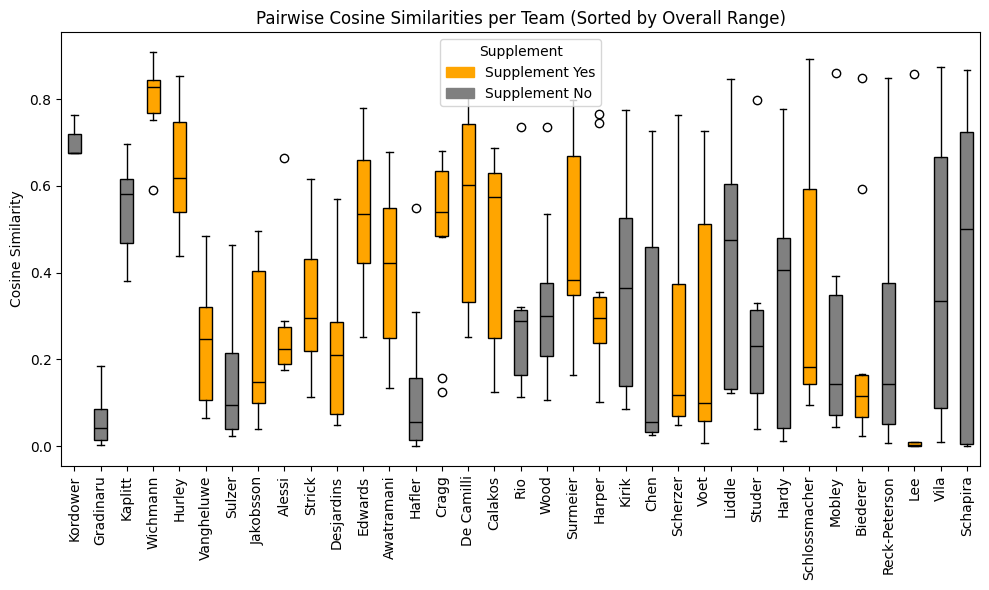

C:\Users\school\AppData\Local\Temp\ipykernel_10264\2307373302.py:117: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(box_data, patch_artist=True, labels=box_order_no_outliers)


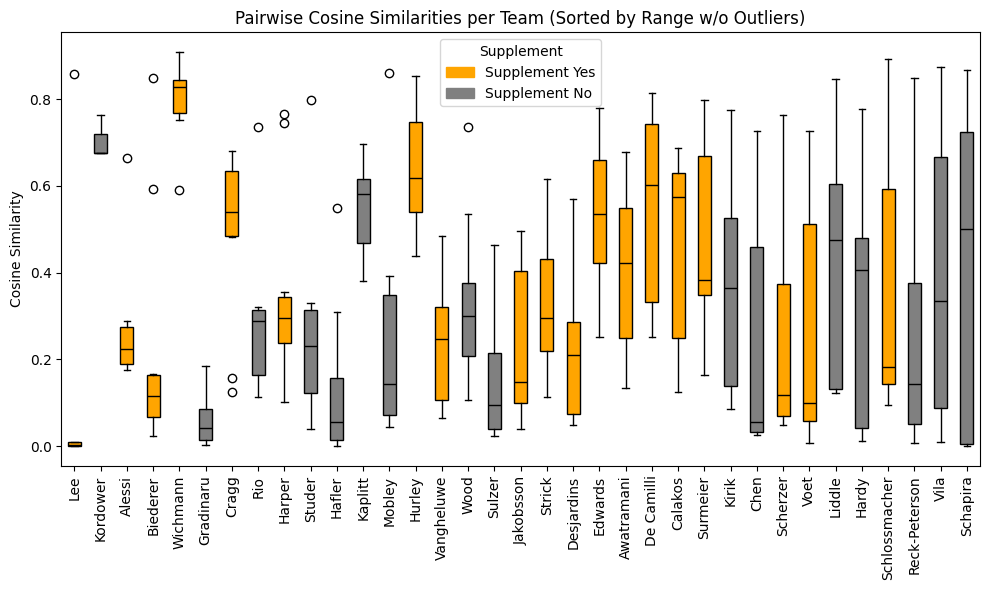

T-test results:
t-statistic = 2.5058, p-value = 0.01281
Mean(Yes) = 0.3833, Mean(No) = 0.3063


In [68]:
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# --- Remove MAC team ---
df = df[df["Team"] != "MAC"]

# Merge to get Supplement info
#df = df.merge(supplement_df, on="Team", how="left")

# --- Store results ---
team_avg_similarities = {}
team_all_similarities = {}
team_pairwise_sims = {}

for team, group in df.groupby("Team"):
    vectors = np.vstack(group["TopicVector"].values)
    sim_matrix = cosine_similarity(vectors)

    # All pairwise similarities
    pairwise = [
        sim_matrix[i, j] 
        for i, j in itertools.combinations(range(len(group)), 2)
    ]

    if pairwise:
        team_avg_similarities[team] = np.mean(pairwise)
        team_all_similarities[team] = sim_matrix[np.triu_indices(len(group), k=1)].tolist()
        team_pairwise_sims[team] = pairwise
    else:
        team_avg_similarities[team] = np.nan
        team_all_similarities[team] = []
        team_pairwise_sims[team] = []

# --- Get colors ---
team_colors = {
    row.Team: ("orange" if row.Supplement == "Yes" else "grey")
    for _, row in supplement_df.iterrows()
}

# --- Sort barplot order (avg similarities, desc, ties by supplement color) ---
bar_order = sorted(
    team_avg_similarities.keys(),
    key=lambda t: (
        -team_avg_similarities[t],
        0 if team_colors[t] == "orange" else 1
    )
)

# --- Bar plot of average similarities ---
plt.figure(figsize=(10, 6))
for team in bar_order:
    plt.bar(team, team_avg_similarities[team], color=team_colors.get(team, "grey"))
plt.ylabel("Average Pairwise Cosine Similarity")
plt.title("Average Pairwise Cosine Similarity per Team")
plt.xticks(rotation=90)
# Legend
handles = [
    plt.Rectangle((0,0),1,1,color="orange",label="Supplement Yes"),
    plt.Rectangle((0,0),1,1,color="grey",label="Supplement No")
]
plt.legend(handles=handles, title="Supplement", loc="best")
plt.tight_layout()
plt.show()

# --- Sort boxplot order (range low to high, ties by supplement color) ---
box_order_overall = sorted(
    team_pairwise_sims.keys(),
    key=lambda t: (
        np.ptp(team_pairwise_sims[t]) if team_pairwise_sims[t] else float("inf"),
        0 if team_colors[t] == "orange" else 1
    )
)

# --- Box plot (overall range) ---
plt.figure(figsize=(10, 6))
box_data = [team_pairwise_sims[t] for t in box_order_overall]
box_colors = [team_colors.get(t, "grey") for t in box_order_overall]
bp = plt.boxplot(box_data, patch_artist=True, labels=box_order_overall)
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
for median in bp['medians']:
    median.set_color("black")
plt.ylabel("Cosine Similarity")
plt.title("Pairwise Cosine Similarities per Team (Sorted by Overall Range)")
plt.xticks(rotation=90)
# Legend
plt.legend(handles=handles, title="Supplement", loc="best")
plt.tight_layout()
plt.show()

# --- Sort boxplot order (range excluding outliers) ---
def range_no_outliers(values):
    if not values:
        return float("inf")
    q1, q3 = np.percentile(values, [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    filtered = [v for v in values if lower <= v <= upper]
    return np.ptp(filtered) if filtered else float("inf")

box_order_no_outliers = sorted(
    team_pairwise_sims.keys(),
    key=lambda t: (
        range_no_outliers(team_pairwise_sims[t]),
        0 if team_colors[t] == "orange" else 1
    )
)

# --- Box plot (range excluding outliers) ---
plt.figure(figsize=(10, 6))
box_data = [team_pairwise_sims[t] for t in box_order_no_outliers]
box_colors = [team_colors.get(t, "grey") for t in box_order_no_outliers]
bp = plt.boxplot(box_data, patch_artist=True, labels=box_order_no_outliers)
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
for median in bp['medians']:
    median.set_color("black")
plt.ylabel("Cosine Similarity")
plt.title("Pairwise Cosine Similarities per Team (Sorted by Range w/o Outliers)")
plt.xticks(rotation=90)
# Legend
plt.legend(handles=handles, title="Supplement", loc="best")
plt.tight_layout()
plt.show()

# --- T-test: Mean cosine similarity by supplement group ---
supp_groups = {"Yes": [], "No": []}
for team, sims in team_pairwise_sims.items():
    if sims:
        supp = supplement_df.loc[supplement_df["Team"] == team, "Supplement"].values[0]
        supp_groups[supp].extend(sims)

t_stat, p_val = ttest_ind(supp_groups["Yes"], supp_groups["No"], equal_var=False)

print("T-test results:")
print(f"t-statistic = {t_stat:.4f}, p-value = {p_val:.4g}")
print(f"Mean(Yes) = {np.mean(supp_groups['Yes']):.4f}, Mean(No) = {np.mean(supp_groups['No']):.4f}")


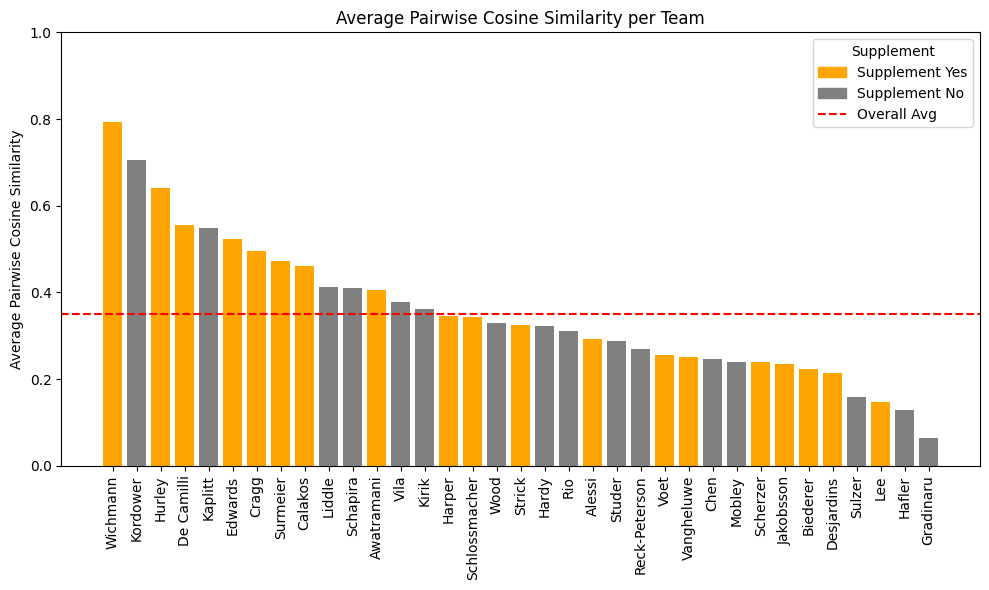

C:\Users\school\AppData\Local\Temp\ipykernel_11736\545186724.py:86: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(box_data, patch_artist=True, labels=box_order_overall)


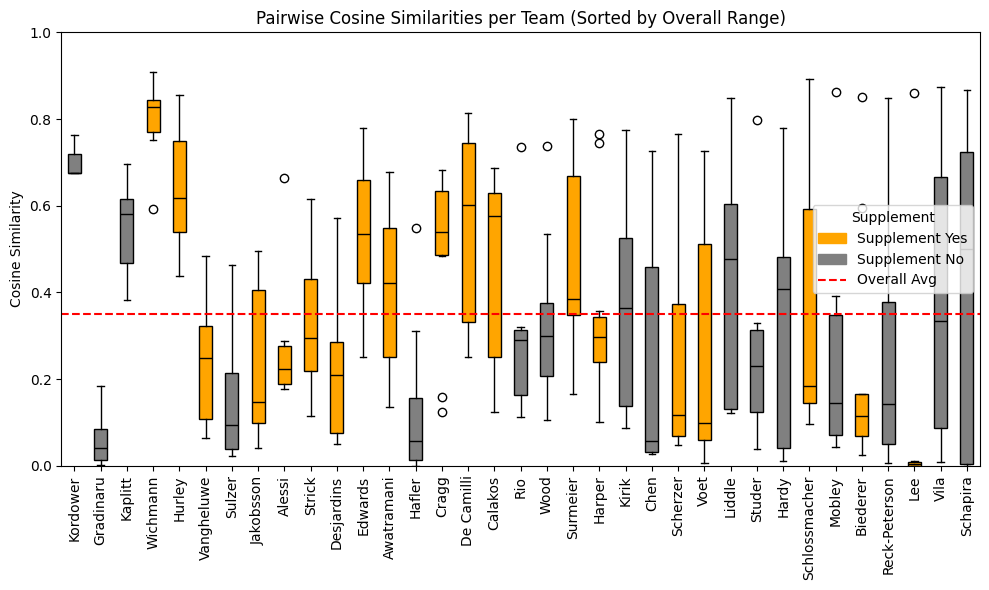

C:\Users\school\AppData\Local\Temp\ipykernel_11736\545186724.py:123: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(box_data, patch_artist=True, labels=box_order_no_outliers)


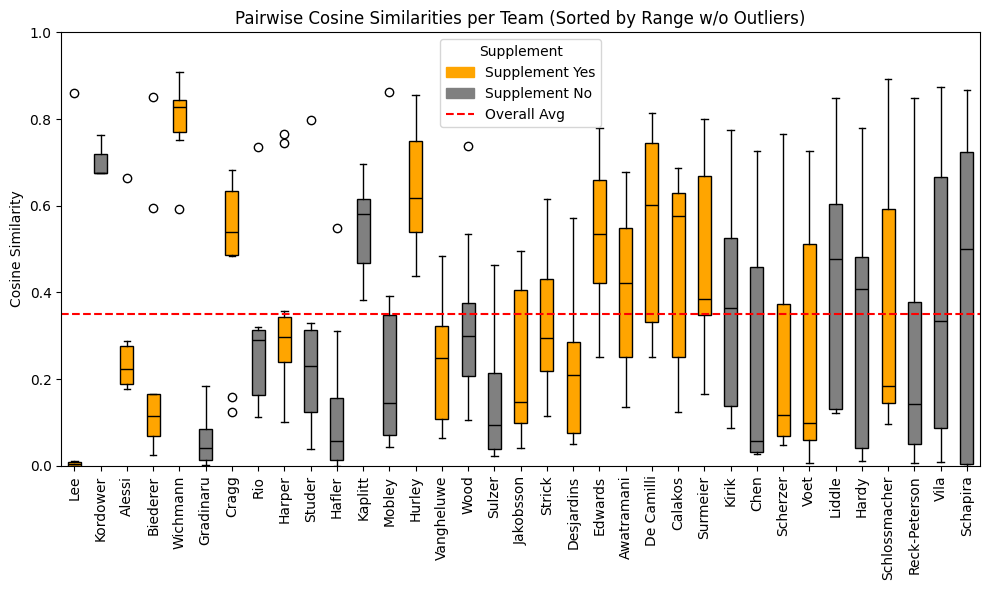

In [31]:
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# --- Remove MAC team ---
df = df[df["Team"] != "MAC"]

# --- Store results ---
team_avg_similarities = {}
team_all_similarities = {}
team_pairwise_sims = {}

for team, group in df.groupby("Team"):
    vectors = np.vstack(group["TopicVector"].values)
    sim_matrix = cosine_similarity(vectors)

    # All pairwise similarities
    pairwise = [
        sim_matrix[i, j] 
        for i, j in itertools.combinations(range(len(group)), 2)
    ]

    if pairwise:
        team_avg_similarities[team] = np.mean(pairwise)
        team_all_similarities[team] = sim_matrix[np.triu_indices(len(group), k=1)].tolist()
        team_pairwise_sims[team] = pairwise
    else:
        team_avg_similarities[team] = np.nan
        team_all_similarities[team] = []
        team_pairwise_sims[team] = []

# --- Get colors ---
team_colors = {
    row.Team: ("orange" if row.Supplement == "Yes" else "grey")
    for _, row in supplement_df.iterrows()
}

# --- Overall average cosine similarity ---
all_pairwise_values = [val for sims in team_pairwise_sims.values() for val in sims]
overall_avg_similarity = np.mean(all_pairwise_values) if all_pairwise_values else 0

# --- Sort barplot order ---
bar_order = sorted(
    team_avg_similarities.keys(),
    key=lambda t: (
        -team_avg_similarities[t],
        0 if team_colors[t] == "orange" else 1
    )
)

# --- Bar plot of average similarities ---
plt.figure(figsize=(10, 6))
for team in bar_order:
    plt.bar(team, team_avg_similarities[team], color=team_colors.get(team, "grey"))
plt.axhline(overall_avg_similarity, color="red", linestyle="--", label="Overall Avg")
plt.ylabel("Average Pairwise Cosine Similarity")
plt.title("Average Pairwise Cosine Similarity per Team")
plt.ylim(0, 1)
plt.xticks(rotation=90)
# Legend
handles = [
    plt.Rectangle((0,0),1,1,color="orange",label="Supplement Yes"),
    plt.Rectangle((0,0),1,1,color="grey",label="Supplement No"),
    plt.Line2D([0], [0], color="red", linestyle="--", label="Overall Avg")
]
plt.legend(handles=handles, title="Supplement", loc="best")
plt.tight_layout()
plt.show()

# --- Sort boxplot order (overall range) ---
box_order_overall = sorted(
    team_pairwise_sims.keys(),
    key=lambda t: (
        np.ptp(team_pairwise_sims[t]) if team_pairwise_sims[t] else float("inf"),
        0 if team_colors[t] == "orange" else 1
    )
)

# --- Box plot (overall range) ---
plt.figure(figsize=(10, 6))
box_data = [team_pairwise_sims[t] for t in box_order_overall]
box_colors = [team_colors.get(t, "grey") for t in box_order_overall]
bp = plt.boxplot(box_data, patch_artist=True, labels=box_order_overall)
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
for median in bp['medians']:
    median.set_color("black")
plt.axhline(overall_avg_similarity, color="red", linestyle="--", label="Overall Avg")
plt.ylabel("Cosine Similarity")
plt.title("Pairwise Cosine Similarities per Team (Sorted by Overall Range)")
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.legend(handles=handles, title="Supplement", loc="best")
plt.tight_layout()
plt.show()

# --- Helper to exclude outliers ---
def range_no_outliers(values):
    if not values:
        return float("inf")
    q1, q3 = np.percentile(values, [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    filtered = [v for v in values if lower <= v <= upper]
    return np.ptp(filtered) if filtered else float("inf")

# --- Sort boxplot order (range excluding outliers) ---
box_order_no_outliers = sorted(
    team_pairwise_sims.keys(),
    key=lambda t: (
        range_no_outliers(team_pairwise_sims[t]),
        0 if team_colors[t] == "orange" else 1
    )
)

# --- Box plot (range excluding outliers) ---
plt.figure(figsize=(10, 6))
box_data = [team_pairwise_sims[t] for t in box_order_no_outliers]
box_colors = [team_colors.get(t, "grey") for t in box_order_no_outliers]
bp = plt.boxplot(box_data, patch_artist=True, labels=box_order_no_outliers)
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
for median in bp['medians']:
    median.set_color("black")
plt.axhline(overall_avg_similarity, color="red", linestyle="--", label="Overall Avg")
plt.ylabel("Cosine Similarity")
plt.title("Pairwise Cosine Similarities per Team (Sorted by Range w/o Outliers)")
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.legend(handles=handles, title="Supplement", loc="best")
plt.tight_layout()
plt.show()


C:\Users\school\AppData\Local\Temp\ipykernel_11736\520944713.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(box_data, patch_artist=True, labels=box_order_overall)


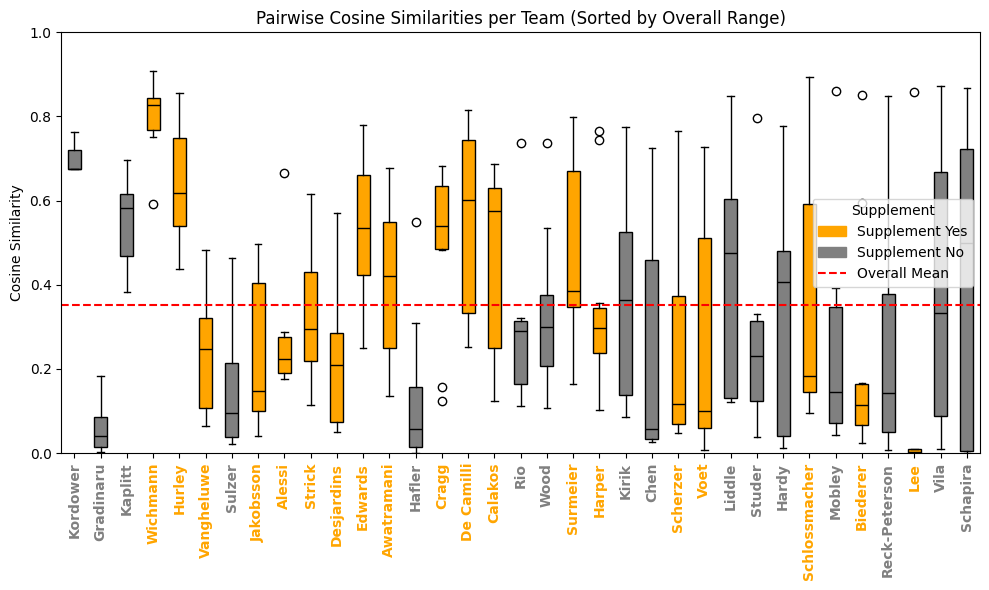

C:\Users\school\AppData\Local\Temp\ipykernel_11736\520944713.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(box_data, patch_artist=True, labels=box_order_no_outliers)


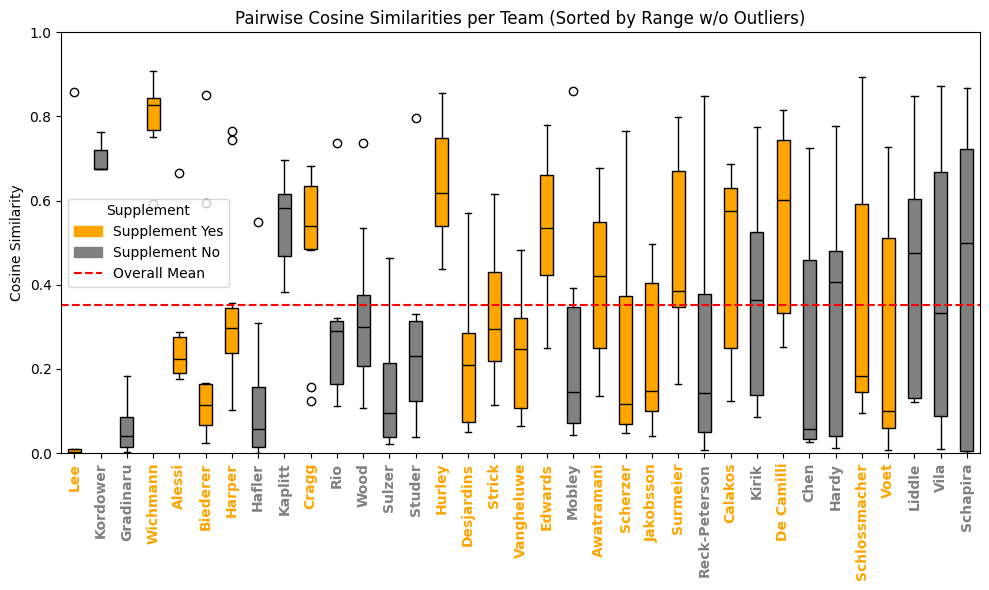

In [34]:
# --- Box plot (overall range) ---
plt.figure(figsize=(10, 6))
box_data = [team_pairwise_sims[t] for t in box_order_overall]
box_colors = [team_colors.get(t, "grey") for t in box_order_overall]

bp = plt.boxplot(box_data, patch_artist=True, labels=box_order_overall)

# Colors
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
for median in bp['medians']:
    median.set_color("black")

# Add horizontal line at overall average similarity
all_sims = [val for sims in team_pairwise_sims.values() for val in sims]
overall_mean = np.mean(all_sims)
plt.axhline(overall_mean, color="red", linestyle="--", label=f"Overall Mean = {overall_mean:.2f}")

plt.ylabel("Cosine Similarity")
plt.title("Pairwise Cosine Similarities per Team (Sorted by Overall Range)")
plt.ylim(0, 1)  # Force scale 0–1

# Set x-ticks at 90 degrees, centered
plt.xticks(
    ticks=range(1, len(box_order_overall) + 1),
    labels=box_order_overall,
    rotation=90,
    ha="center",  # keep vertical alignment
    fontweight="bold"
)

# Color labels
ax = plt.gca()
for label, team in zip(ax.get_xticklabels(), box_order_overall):
    label.set_color(team_colors.get(team, "grey"))
    label.set_fontweight("bold")

# Legend
handles = [
    plt.Rectangle((0,0),1,1,color="orange",label="Supplement Yes"),
    plt.Rectangle((0,0),1,1,color="grey",label="Supplement No")
]
plt.legend(handles=handles+[plt.Line2D([0],[0],color="red",linestyle="--",label="Overall Mean")],
           title="Supplement", loc="best")

plt.tight_layout()
plt.show()


# --- Box plot (range excluding outliers) ---
plt.figure(figsize=(10, 6))
box_data = [team_pairwise_sims[t] for t in box_order_no_outliers]
box_colors = [team_colors.get(t, "grey") for t in box_order_no_outliers]

bp = plt.boxplot(box_data, patch_artist=True, labels=box_order_no_outliers)

# Colors
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
for median in bp['medians']:
    median.set_color("black")

# Add horizontal line at overall average similarity
plt.axhline(overall_mean, color="red", linestyle="--", label=f"Overall Mean = {overall_mean:.2f}")

plt.ylabel("Cosine Similarity")
plt.title("Pairwise Cosine Similarities per Team (Sorted by Range w/o Outliers)")
plt.ylim(0, 1)  # Force scale 0–1

# Set x-ticks at 90 degrees
plt.xticks(
    ticks=range(1, len(box_order_no_outliers) + 1),
    labels=box_order_no_outliers,
    rotation=90,
    ha="center",
    fontweight="bold"
)

# Color labels
ax = plt.gca()
for label, team in zip(ax.get_xticklabels(), box_order_no_outliers):
    label.set_color(team_colors.get(team, "grey"))
    label.set_fontweight("bold")

# Legend
handles = [
    plt.Rectangle((0,0),1,1,color="orange",label="Supplement Yes"),
    plt.Rectangle((0,0),1,1,color="grey",label="Supplement No")
]
plt.legend(handles=handles+[plt.Line2D([0],[0],color="red",linestyle="--",label="Overall Mean")],
           title="Supplement", loc="best")

plt.tight_layout()
plt.show()


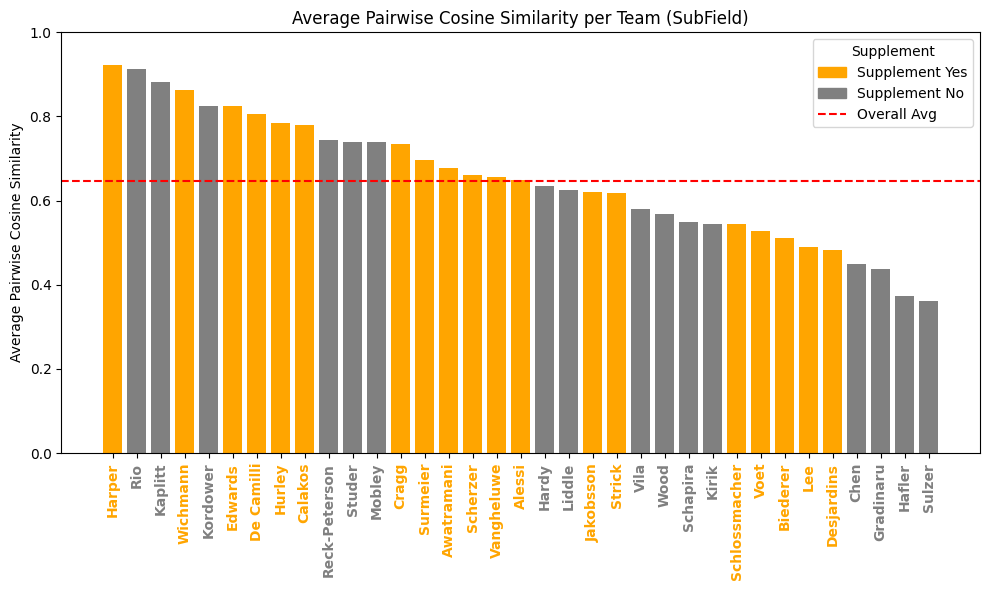

C:\Users\school\AppData\Local\Temp\ipykernel_11736\697200384.py:91: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(box_data, patch_artist=True, labels=box_order_overall)


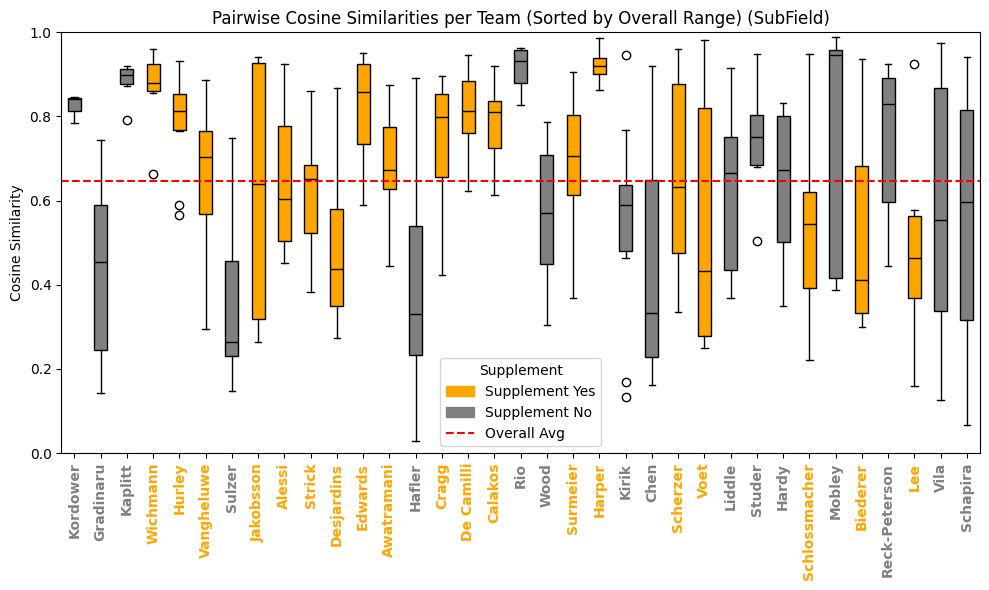

C:\Users\school\AppData\Local\Temp\ipykernel_11736\697200384.py:132: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(box_data, patch_artist=True, labels=box_order_no_outliers)


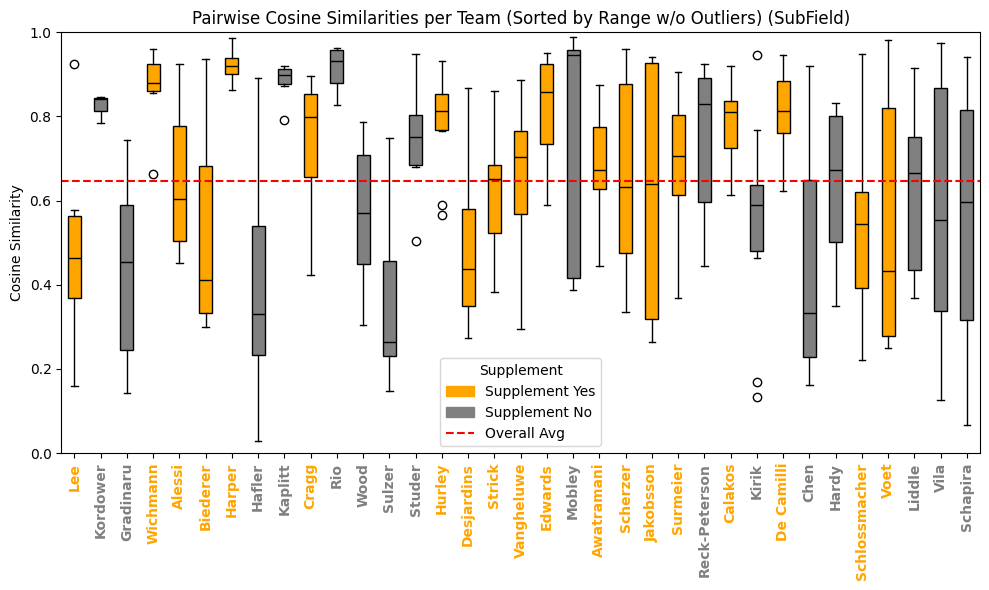

In [35]:
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# --- Remove MAC team ---
df = df[df["Team"] != "MAC"]

# --- Store results ---
team_avg_similarities = {}
team_all_similarities = {}
team_pairwise_sims = {}

for team, group in df.groupby("Team"):
    vectors = np.vstack(group["SubFieldVector"].values)
    sim_matrix = cosine_similarity(vectors)

    # All pairwise similarities
    pairwise = [
        sim_matrix[i, j] 
        for i, j in itertools.combinations(range(len(group)), 2)
    ]

    if pairwise:
        team_avg_similarities[team] = np.mean(pairwise)
        team_all_similarities[team] = sim_matrix[np.triu_indices(len(group), k=1)].tolist()
        team_pairwise_sims[team] = pairwise
    else:
        team_avg_similarities[team] = np.nan
        team_all_similarities[team] = []
        team_pairwise_sims[team] = []

# --- Get colors ---
team_colors = {
    row.Team: ("orange" if row.Supplement == "Yes" else "grey")
    for _, row in supplement_df.iterrows()
}

# --- Global average cosine similarity (all teams, all pairs) ---
all_pairwise = [val for sims in team_pairwise_sims.values() for val in sims]
overall_avg = np.mean(all_pairwise) if all_pairwise else np.nan

# --- Sort barplot order (avg similarities, desc, ties by supplement color) ---
bar_order = sorted(
    team_avg_similarities.keys(),
    key=lambda t: (
        -team_avg_similarities[t],
        0 if team_colors[t] == "orange" else 1
    )
)

# --- Bar plot of average similarities ---
plt.figure(figsize=(10, 6))
for team in bar_order:
    plt.bar(team, team_avg_similarities[team], color=team_colors.get(team, "grey"))

plt.axhline(overall_avg, color="red", linestyle="--", linewidth=1.5, label=f"Overall Avg = {overall_avg:.2f}")
plt.ylabel("Average Pairwise Cosine Similarity")
plt.title("Average Pairwise Cosine Similarity per Team (SubField)")
plt.ylim(0, 1)   # Force scale 0–1

# Set x-ticks
xticks_positions = range(len(bar_order))
plt.xticks(ticks=xticks_positions, labels=bar_order, rotation=90, fontweight="bold")

# Color each label individually
ax = plt.gca()
for label, team in zip(ax.get_xticklabels(), bar_order):
    label.set_color(team_colors.get(team, "grey"))
    label.set_fontweight("bold")

# Legend
handles = [
    plt.Rectangle((0,0),1,1,color="orange",label="Supplement Yes"),
    plt.Rectangle((0,0),1,1,color="grey",label="Supplement No"),
]
handles.append(plt.Line2D([0], [0], color="red", linestyle="--", label="Overall Avg"))
plt.legend(handles=handles, title="Supplement", loc="best")

plt.tight_layout()
#plt.savefig('subfield_pairwise_cosine_similarity_barplot.png')
plt.show()


# --- Box plot (overall range) ---
plt.figure(figsize=(10, 6))
box_data = [team_pairwise_sims[t] for t in box_order_overall]
box_colors = [team_colors.get(t, "grey") for t in box_order_overall]
bp = plt.boxplot(box_data, patch_artist=True, labels=box_order_overall)

for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
for median in bp['medians']:
    median.set_color("black")

plt.axhline(overall_avg, color="red", linestyle="--", linewidth=1.5, label=f"Overall Avg = {overall_avg:.2f}")
plt.ylabel("Cosine Similarity")
plt.title("Pairwise Cosine Similarities per Team (Sorted by Overall Range) (SubField)")
plt.ylim(0, 1)   # Force scale 0–1

# Set ticks
plt.xticks(ticks=range(1, len(box_order_overall) + 1),
           labels=box_order_overall,
           rotation=90,
           fontweight="bold")

# Color each label individually
ax = plt.gca()
for label, team in zip(ax.get_xticklabels(), box_order_overall):
    label.set_color(team_colors.get(team, "grey"))
    label.set_fontweight("bold")

# Legend
handles = [
    plt.Rectangle((0,0),1,1,color="orange",label="Supplement Yes"),
    plt.Rectangle((0,0),1,1,color="grey",label="Supplement No"),
]
handles.append(plt.Line2D([0], [0], color="red", linestyle="--", label="Overall Avg"))
plt.legend(handles=handles, title="Supplement", loc="best")

plt.tight_layout()
#plt.savefig('subfield_pairwise_cosine_similarity_boxplot.png')
plt.show()


# --- Box plot (range excluding outliers) ---
plt.figure(figsize=(10, 6))
box_data = [team_pairwise_sims[t] for t in box_order_no_outliers]
box_colors = [team_colors.get(t, "grey") for t in box_order_no_outliers]
bp = plt.boxplot(box_data, patch_artist=True, labels=box_order_no_outliers)

for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
for median in bp['medians']:
    median.set_color("black")

plt.axhline(overall_avg, color="red", linestyle="--", linewidth=1.5, label=f"Overall Avg = {overall_avg:.2f}")
plt.ylabel("Cosine Similarity")
plt.title("Pairwise Cosine Similarities per Team (Sorted by Range w/o Outliers) (SubField)")
plt.ylim(0, 1)   # Force scale 0–1

# Set ticks
plt.xticks(ticks=range(1, len(box_order_no_outliers) + 1),
           labels=box_order_no_outliers,
           rotation=90,
           fontweight="bold")

# Color each label individually
ax = plt.gca()
for label, team in zip(ax.get_xticklabels(), box_order_no_outliers):
    label.set_color(team_colors.get(team, "grey"))
    label.set_fontweight("bold")

# Legend
handles = [
    plt.Rectangle((0,0),1,1,color="orange",label="Supplement Yes"),
    plt.Rectangle((0,0),1,1,color="grey",label="Supplement No"),
]
handles.append(plt.Line2D([0], [0], color="red", linestyle="--", label="Overall Avg"))
plt.legend(handles=handles, title="Supplement", loc="best")

plt.tight_layout()
#plt.savefig('subfield_pairwise_cosine_similarity_boxplot_no_outliers.png')
plt.show()


In [66]:
from scipy.stats import mannwhitneyu

u_stat, p_value_u = mannwhitneyu(supp_groups["Yes"], supp_groups["No"], alternative='two-sided')
print(f"Mann-Whitney U test: U = {u_stat}, p = {p_value_u:.4f}")



Mann-Whitney U test: U = 13814.5, p = 0.0033


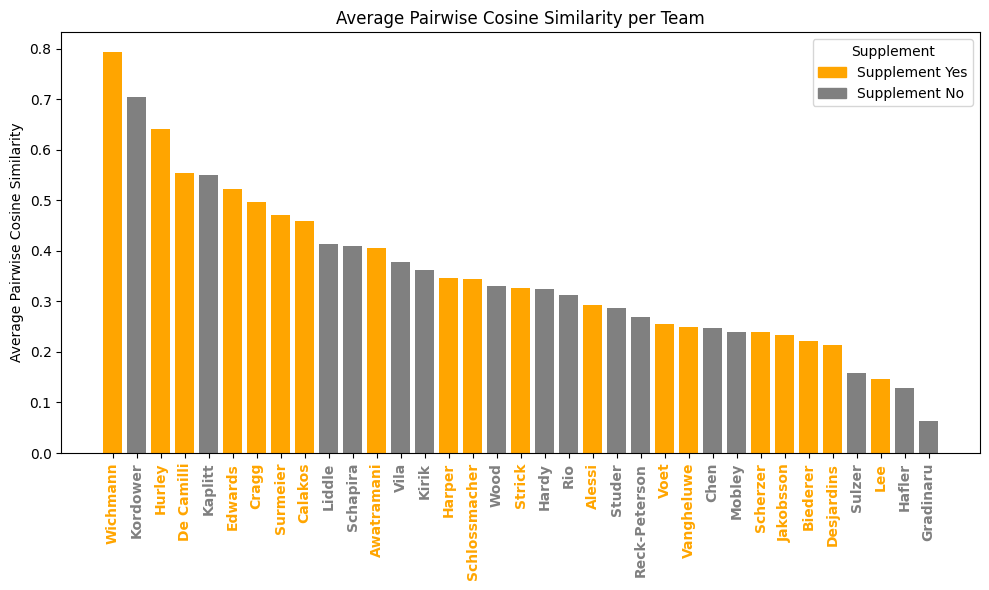

C:\Users\school\AppData\Local\Temp\ipykernel_10264\4219578972.py:86: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(box_data, patch_artist=True, labels=box_order_overall)


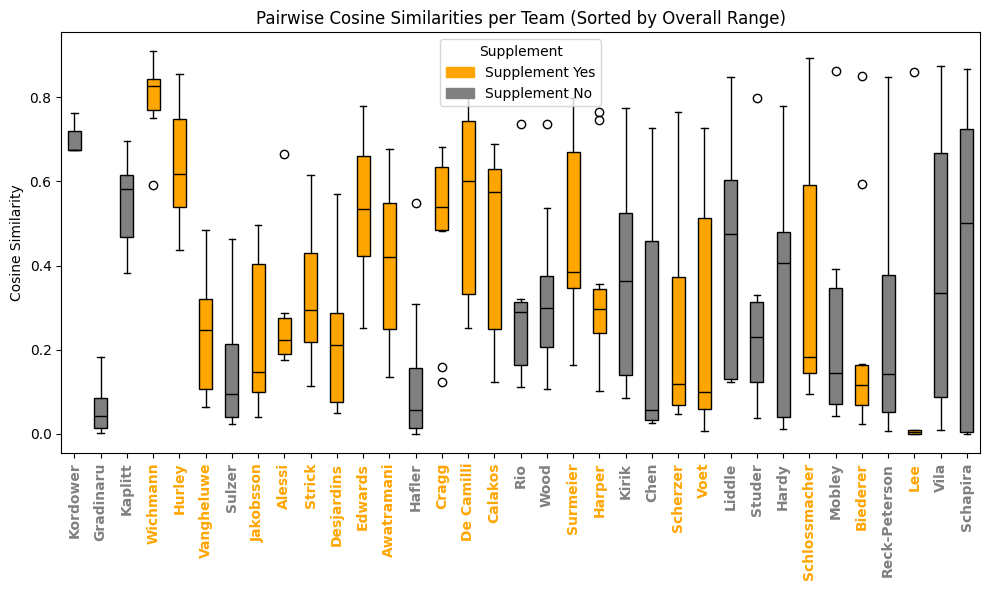

C:\Users\school\AppData\Local\Temp\ipykernel_10264\4219578972.py:119: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(box_data, patch_artist=True, labels=box_order_no_outliers)


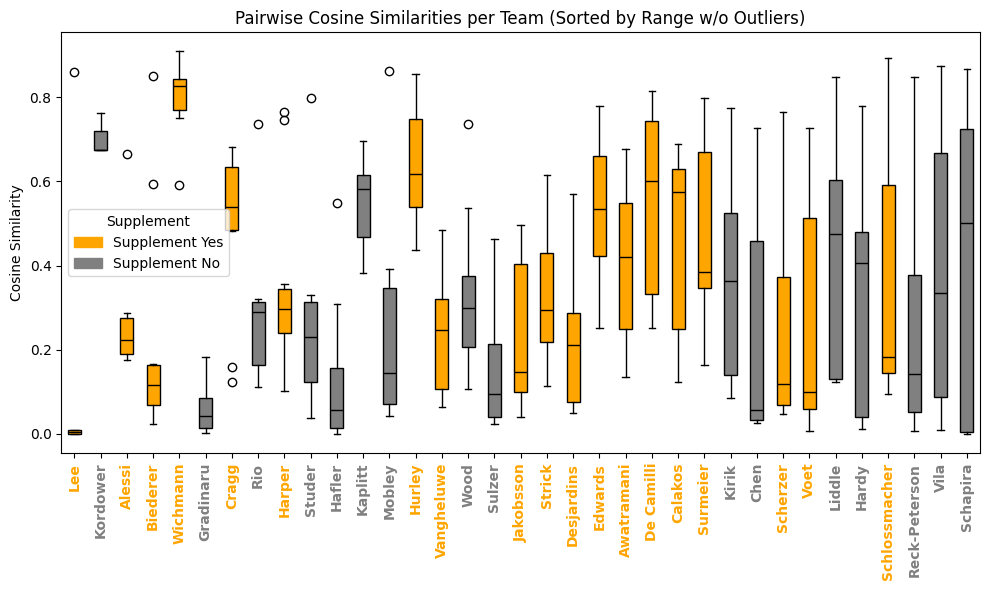

In [69]:
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# --- Remove MAC team ---
df = df[df["Team"] != "MAC"]

# Merge to get Supplement info
#df = df.merge(supplement_df, on="Team", how="left")

# --- Store results ---
team_avg_similarities = {}
team_all_similarities = {}
team_pairwise_sims = {}

for team, group in df.groupby("Team"):
    vectors = np.vstack(group["TopicVector"].values)
    sim_matrix = cosine_similarity(vectors)

    # All pairwise similarities
    pairwise = [
        sim_matrix[i, j] 
        for i, j in itertools.combinations(range(len(group)), 2)
    ]

    if pairwise:
        team_avg_similarities[team] = np.mean(pairwise)
        team_all_similarities[team] = sim_matrix[np.triu_indices(len(group), k=1)].tolist()
        team_pairwise_sims[team] = pairwise
    else:
        team_avg_similarities[team] = np.nan
        team_all_similarities[team] = []
        team_pairwise_sims[team] = []

# --- Get colors ---
team_colors = {
    row.Team: ("orange" if row.Supplement == "Yes" else "grey")
    for _, row in supplement_df.iterrows()
}

# --- Sort barplot order (avg similarities, desc, ties by supplement color) ---
bar_order = sorted(
    team_avg_similarities.keys(),
    key=lambda t: (
        -team_avg_similarities[t],
        0 if team_colors[t] == "orange" else 1
    )
)

# --- Bar plot of average similarities ---
plt.figure(figsize=(10, 6))
for team in bar_order:
    plt.bar(team, team_avg_similarities[team], color=team_colors.get(team, "grey"))

plt.ylabel("Average Pairwise Cosine Similarity")
plt.title("Average Pairwise Cosine Similarity per Team")

# Set x-ticks
xticks_positions = range(len(bar_order))
plt.xticks(ticks=xticks_positions, labels=bar_order, rotation=90, fontweight="bold")

# Color each label individually
ax = plt.gca()
for label, team in zip(ax.get_xticklabels(), bar_order):
    label.set_color(team_colors.get(team, "grey"))
    label.set_fontweight("bold")

# Legend
handles = [
    plt.Rectangle((0,0),1,1,color="orange",label="Supplement Yes"),
    plt.Rectangle((0,0),1,1,color="grey",label="Supplement No")
]
plt.legend(handles=handles, title="Supplement", loc="best")
plt.tight_layout()
#plt.savefig('topic_pairwise_cosine_similarity_barplot.png')
plt.show()


# --- Box plot (overall range) ---
plt.figure(figsize=(10, 6))
box_data = [team_pairwise_sims[t] for t in box_order_overall]
box_colors = [team_colors.get(t, "grey") for t in box_order_overall]
bp = plt.boxplot(box_data, patch_artist=True, labels=box_order_overall)
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
for median in bp['medians']:
    median.set_color("black")
plt.ylabel("Cosine Similarity")
plt.title("Pairwise Cosine Similarities per Team (Sorted by Overall Range)")
# Set ticks without colors
plt.xticks(ticks=range(1, len(box_order_overall) + 1),
           labels=box_order_overall,
           rotation=90,
           fontweight="bold")

# Color each label individually
ax = plt.gca()
for label, team in zip(ax.get_xticklabels(), box_order_overall):
    label.set_color(team_colors.get(team, "grey"))
    label.set_fontweight("bold")

# Legend
handles = [
    plt.Rectangle((0,0),1,1,color="orange",label="Supplement Yes"),
    plt.Rectangle((0,0),1,1,color="grey",label="Supplement No")
]
plt.legend(handles=handles, title="Supplement", loc="best")
plt.tight_layout()
#plt.savefig('topic_pairwise_cosine_similarity_boxplot.png')
plt.show()

# --- Box plot (range excluding outliers) ---
plt.figure(figsize=(10, 6))
box_data = [team_pairwise_sims[t] for t in box_order_no_outliers]
box_colors = [team_colors.get(t, "grey") for t in box_order_no_outliers]
bp = plt.boxplot(box_data, patch_artist=True, labels=box_order_no_outliers)
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
for median in bp['medians']:
    median.set_color("black")
plt.ylabel("Cosine Similarity")
plt.title("Pairwise Cosine Similarities per Team (Sorted by Range w/o Outliers)")
# Set ticks without colors
plt.xticks(ticks=range(1, len(box_order_no_outliers) + 1),
           labels=box_order_no_outliers,
           rotation=90,
           fontweight="bold")

# Color each label individually
ax = plt.gca()
for label, team in zip(ax.get_xticklabels(), box_order_no_outliers):
    label.set_color(team_colors.get(team, "grey"))
    label.set_fontweight("bold")

# Legend
handles = [
    plt.Rectangle((0,0),1,1,color="orange",label="Supplement Yes"),
    plt.Rectangle((0,0),1,1,color="grey",label="Supplement No")
]
plt.legend(handles=handles, title="Supplement", loc="best")

plt.tight_layout()
#plt.savefig('topic_pairwise_cosine_similarity_boxplot_no_outliers.png')
plt.show()


In [49]:
import requests
import pandas as pd

def fetch_subfields_for_work(work_id):
    """Fetch list of topic IDs for a single work ID."""
    try:
        url = f"https://api.openalex.org/works/{work_id}"
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()

        topics = []
        for topic in data.get("topics", []):
            if "id" in topic:
                topics.append(topic["subfield"]["id"])
        return topics
    except Exception as e:
        print(f"Error fetching topics for work {work_id}: {e}")
        return []

def fetch_subfields_for_author(work_id_list):
    """Fetch all topic IDs (with duplicates) for a list of work IDs."""
    all_topics = []
    for wid in work_id_list:
        all_topics.extend(fetch_subfields_for_work(wid))
    return all_topics

# Apply to DataFrame
df["ListOfSubFields"] = df["OpenAlex_Work_IDs"].apply(fetch_subfields_for_author)


In [51]:
prefix = "https://openalex.org/subfields/"

df["ListOfSubFields"] = df["ListOfSubFields"].apply(
    lambda lst: [item[len(prefix):] if item.startswith(prefix) else item for item in lst]
)


In [53]:
df.to_csv('team_roster_with_subfields.csv')

In [54]:
import pandas as pd

# Step 1: Get all unique topics across all people, preserve order
all_unique_topics = sorted(set(topic for topics in df["ListOfSubFields"] for topic in topics))

# Step 2: Assign this as the "vector positions" column (same for all rows)
df["SubFieldVectorPositions"] = [all_unique_topics] * len(df)

# Step 3: Create the topic count vector for each row
def make_topic_vector(person_topics, all_topics):
    counts = [person_topics.count(topic) for topic in all_topics]
    return counts

df["SubFieldVector"] = df["ListOfSubFields"].apply(lambda topics: make_topic_vector(topics, all_unique_topics))


In [56]:
df.to_csv('team_roster_with_subfield_vector.csv')

In [62]:
def full_range(lst):
    if len(lst) == 0:
        return -np.inf  # Put empty teams at the start or end
    return max(lst) - min(lst)

def iqr_range(lst):
    if len(lst) < 4:
        return full_range(lst)  # fallback for small lists
    q75, q25 = np.percentile(lst, [75 ,25])
    return q75 - q25

def sort_key(team, range_func):
    # Negative range because you want ascending order in boxplots (least to greatest)
    # For ties, orange ("Yes") first (0), grey ("No") second (1)
    return (
        range_func(team_pairwise_sims.get(team, [])),
        0 if team_colors.get(team, "grey") == "orange" else 1
    )

# Sort for boxplot with full range
box_order_overall = sorted(team_pairwise_sims.keys(), key=lambda t: sort_key(t, full_range))

# Sort for boxplot excluding outliers (IQR range)
box_order_no_outliers = sorted(team_pairwise_sims.keys(), key=lambda t: sort_key(t, iqr_range))


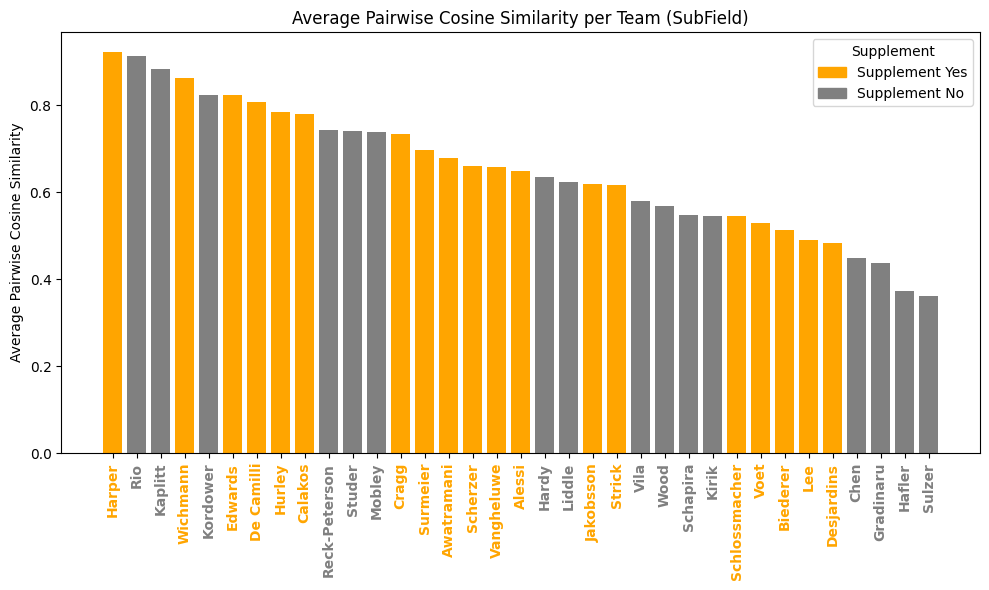

C:\Users\school\AppData\Local\Temp\ipykernel_10264\335724111.py:86: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(box_data, patch_artist=True, labels=box_order_overall)


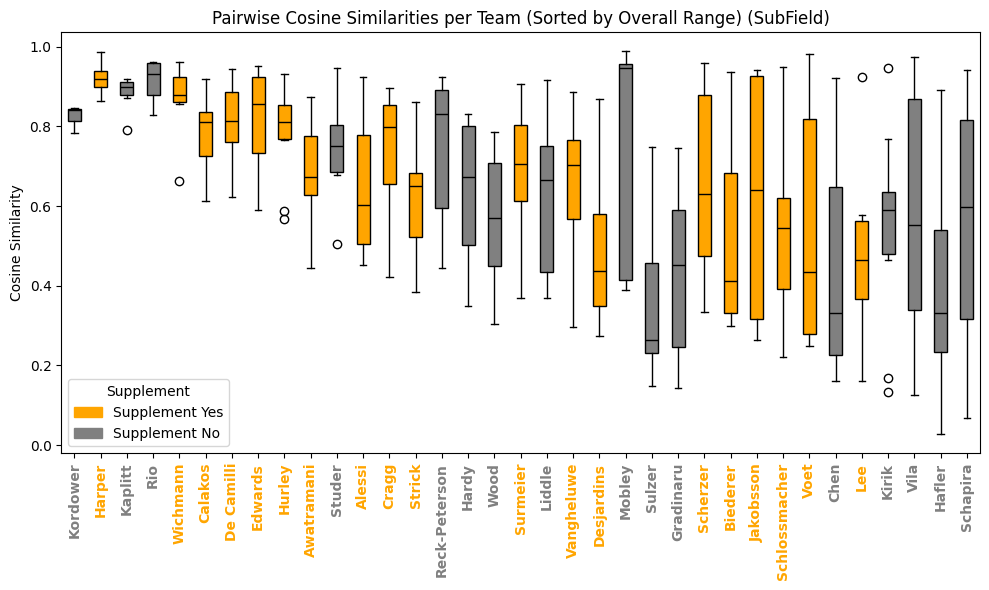

C:\Users\school\AppData\Local\Temp\ipykernel_10264\335724111.py:119: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(box_data, patch_artist=True, labels=box_order_no_outliers)


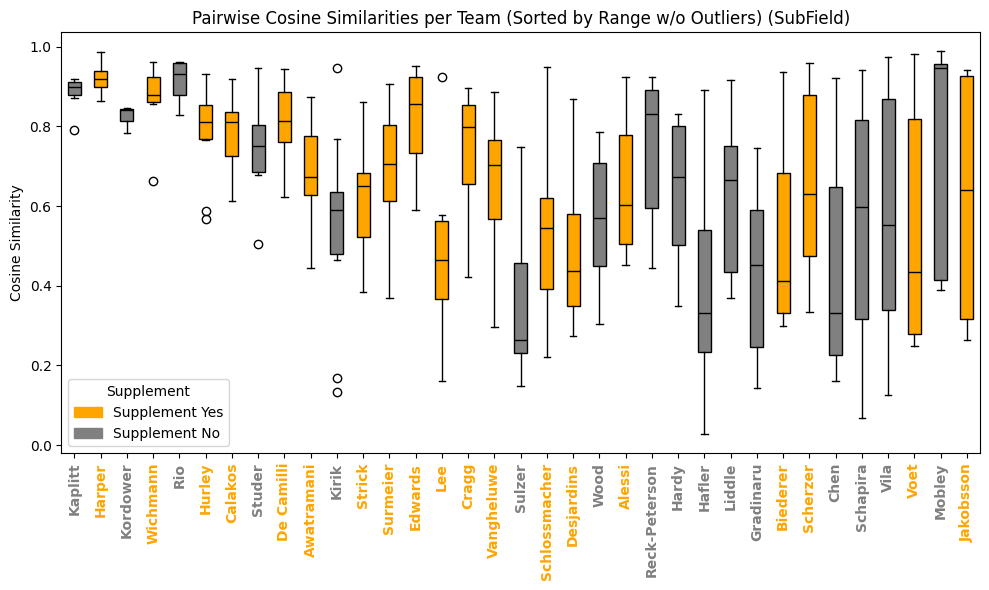

In [63]:
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# --- Remove MAC team ---
df = df[df["Team"] != "MAC"]

# Merge to get Supplement info
#df = df.merge(supplement_df, on="Team", how="left")

# --- Store results ---
team_avg_similarities = {}
team_all_similarities = {}
team_pairwise_sims = {}

for team, group in df.groupby("Team"):
    vectors = np.vstack(group["SubFieldVector"].values)
    sim_matrix = cosine_similarity(vectors)

    # All pairwise similarities
    pairwise = [
        sim_matrix[i, j] 
        for i, j in itertools.combinations(range(len(group)), 2)
    ]

    if pairwise:
        team_avg_similarities[team] = np.mean(pairwise)
        team_all_similarities[team] = sim_matrix[np.triu_indices(len(group), k=1)].tolist()
        team_pairwise_sims[team] = pairwise
    else:
        team_avg_similarities[team] = np.nan
        team_all_similarities[team] = []
        team_pairwise_sims[team] = []

# --- Get colors ---
team_colors = {
    row.Team: ("orange" if row.Supplement == "Yes" else "grey")
    for _, row in supplement_df.iterrows()
}

# --- Sort barplot order (avg similarities, desc, ties by supplement color) ---
bar_order = sorted(
    team_avg_similarities.keys(),
    key=lambda t: (
        -team_avg_similarities[t],
        0 if team_colors[t] == "orange" else 1
    )
)

# --- Bar plot of average similarities ---
plt.figure(figsize=(10, 6))
for team in bar_order:
    plt.bar(team, team_avg_similarities[team], color=team_colors.get(team, "grey"))

plt.ylabel("Average Pairwise Cosine Similarity")
plt.title("Average Pairwise Cosine Similarity per Team (SubField)")

# Set x-ticks
xticks_positions = range(len(bar_order))
plt.xticks(ticks=xticks_positions, labels=bar_order, rotation=90, fontweight="bold")

# Color each label individually
ax = plt.gca()
for label, team in zip(ax.get_xticklabels(), bar_order):
    label.set_color(team_colors.get(team, "grey"))
    label.set_fontweight("bold")

# Legend
handles = [
    plt.Rectangle((0,0),1,1,color="orange",label="Supplement Yes"),
    plt.Rectangle((0,0),1,1,color="grey",label="Supplement No")
]
plt.legend(handles=handles, title="Supplement", loc="best")
plt.tight_layout()
plt.savefig('subfield_pairwise_cosine_similarity_barplot.png')
plt.show()


# --- Box plot (overall range) ---
plt.figure(figsize=(10, 6))
box_data = [team_pairwise_sims[t] for t in box_order_overall]
box_colors = [team_colors.get(t, "grey") for t in box_order_overall]
bp = plt.boxplot(box_data, patch_artist=True, labels=box_order_overall)
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
for median in bp['medians']:
    median.set_color("black")
plt.ylabel("Cosine Similarity")
plt.title("Pairwise Cosine Similarities per Team (Sorted by Overall Range) (SubField)")
# Set ticks without colors
plt.xticks(ticks=range(1, len(box_order_overall) + 1),
           labels=box_order_overall,
           rotation=90,
           fontweight="bold")

# Color each label individually
ax = plt.gca()
for label, team in zip(ax.get_xticklabels(), box_order_overall):
    label.set_color(team_colors.get(team, "grey"))
    label.set_fontweight("bold")

# Legend
handles = [
    plt.Rectangle((0,0),1,1,color="orange",label="Supplement Yes"),
    plt.Rectangle((0,0),1,1,color="grey",label="Supplement No")
]
plt.legend(handles=handles, title="Supplement", loc="best")
plt.tight_layout()
plt.savefig('subfield_pairwise_cosine_similarity_boxplot.png')
plt.show()

# --- Box plot (range excluding outliers) ---
plt.figure(figsize=(10, 6))
box_data = [team_pairwise_sims[t] for t in box_order_no_outliers]
box_colors = [team_colors.get(t, "grey") for t in box_order_no_outliers]
bp = plt.boxplot(box_data, patch_artist=True, labels=box_order_no_outliers)
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
for median in bp['medians']:
    median.set_color("black")
plt.ylabel("Cosine Similarity")
plt.title("Pairwise Cosine Similarities per Team (Sorted by Range w/o Outliers) (SubField)")
# Set ticks without colors
plt.xticks(ticks=range(1, len(box_order_no_outliers) + 1),
           labels=box_order_no_outliers,
           rotation=90,
           fontweight="bold")

# Color each label individually
ax = plt.gca()
for label, team in zip(ax.get_xticklabels(), box_order_no_outliers):
    label.set_color(team_colors.get(team, "grey"))
    label.set_fontweight("bold")

# Legend
handles = [
    plt.Rectangle((0,0),1,1,color="orange",label="Supplement Yes"),
    plt.Rectangle((0,0),1,1,color="grey",label="Supplement No")
]
plt.legend(handles=handles, title="Supplement", loc="best")

plt.tight_layout()
plt.savefig('subfield_pairwise_cosine_similarity_boxplot_no_outliers.png')
plt.show()


In [64]:
# Flatten pairwise sims by supplement group
yes_sims = []
no_sims = []

for team, sims in team_pairwise_sims.items():
    if team_colors.get(team, "grey") == "orange":  # Supplement == "Yes"
        yes_sims.extend(sims)
    else:
        no_sims.extend(sims)
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(yes_sims, no_sims, equal_var=False)  # Welch's t-test
print(f"T-test: t = {t_stat:.4f}, p = {p_value:.4f}")
print(f"Mean similarity (Supplement=Yes): {np.mean(yes_sims):.4f}")
print(f"Mean similarity (Supplement=No): {np.mean(no_sims):.4f}")


T-test: t = 2.7475, p = 0.0065
Mean similarity (Supplement=Yes): 0.6787
Mean similarity (Supplement=No): 0.6009


In [65]:
from scipy.stats import mannwhitneyu

u_stat, p_value_u = mannwhitneyu(yes_sims, no_sims, alternative='two-sided')
print(f"Mann-Whitney U test: U = {u_stat}, p = {p_value_u:.4f}")



Mann-Whitney U test: U = 13304.0, p = 0.0226


In [72]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
from scipy.stats import mannwhitneyu

# Example: `df` has columns ['Team', 'Supplement', 'TopicVector', 'SubfieldVector']
# TopicVector / SubfieldVector are lists or numpy arrays

def cosine_similarity(a, b):
    return 1 - cosine(a, b)

def pairwise_cosine(df, vector_col):
    results = []
    for i in range(len(df)):
        for j in range(i + 1, len(df)):
            sim = cosine_similarity(df.iloc[i][vector_col], df.iloc[j][vector_col])
            results.append({
                'Team1': df.iloc[i]['Team'],
                'Team2': df.iloc[j]['Team'],
                'Supp1': df.iloc[i]['Supplement'],
                'Supp2': df.iloc[j]['Supplement'],
                'Similarity': sim
            })
    return pd.DataFrame(results)

# Generate pairwise similarity DataFrames
topic_sims = pairwise_cosine(df, 'TopicVector')
subfield_sims = pairwise_cosine(df, 'SubFieldVector')

# Compare similarities between groups
def compare_groups(sim_df):
    same_supp = sim_df[sim_df['Supp1'] == sim_df['Supp2']]['Similarity']
    diff_supp = sim_df[sim_df['Supp1'] != sim_df['Supp2']]['Similarity']
    stat, pval = mannwhitneyu(same_supp, diff_supp, alternative='two-sided')
    return {
        'Same Supplement Mean': same_supp.mean(),
        'Different Supplement Mean': diff_supp.mean(),
        'Mann–Whitney U': stat,
        'p-value': pval
    }

topic_results = compare_groups(topic_sims)
subfield_results = compare_groups(subfield_sims)

print("Topic Similarity Test:", topic_results)
print("Subfield Similarity Test:", subfield_results)


Topic Similarity Test: {'Same Supplement Mean': np.float64(0.20425664497771734), 'Different Supplement Mean': np.float64(0.168879080097414), 'Mann–Whitney U': np.float64(24189538.0), 'p-value': np.float64(7.357680342759293e-17)}
Subfield Similarity Test: {'Same Supplement Mean': np.float64(0.5100381378799451), 'Different Supplement Mean': np.float64(0.49476813270037495), 'Mann–Whitney U': np.float64(23074740.0), 'p-value': np.float64(0.0008339359119948824)}


In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume we already have df_means from the barplot step with:
# 'Team', 'Mean_Topic_Cosine', 'Mean_Subfield_Cosine', 'Supplement'

# Define colors
color_map = {'Yes': 'orange', 'No': 'grey'}
df_means['Color'] = df_means['Supplement'].map(color_map)

plt.figure(figsize=(10, 8))

# Scatterplot
plt.scatter(
    df_means['Mean_Subfield_Cosine'],
    df_means['Mean_Topic_Cosine'],
    c=df_means['Color'],
    s=100,
    edgecolor='black'
)

# Add labels to points
for _, row in df_means.iterrows():
    plt.text(
        row['Mean_Subfield_Cosine'] + 0.002,
        row['Mean_Topic_Cosine'],
        row['Team'],
        fontsize=9,
        fontweight='bold',
        color=row['Color']
    )

# Labels & formatting
plt.xlabel("Mean Subfield Cosine Similarity")
plt.ylabel("Mean Topic Cosine Similarity")
plt.title("Mean Topic vs. Subfield Cosine Similarity by Team", fontsize=14, fontweight='bold')

# Legend
for supplement_value, color in color_map.items():
    plt.scatter([], [], c=color, label=f"Supplement: {supplement_value}", s=100, edgecolor='black')
plt.legend(title="Supplement Group")

# Optional regression line
sns.regplot(
    x='Mean_Subfield_Cosine',
    y='Mean_Topic_Cosine',
    data=df_means,
    scatter=False,
    ci=None,
    color='black',
    line_kws={'linestyle':'--'}
)

plt.show()


NameError: name 'df_means' is not defined

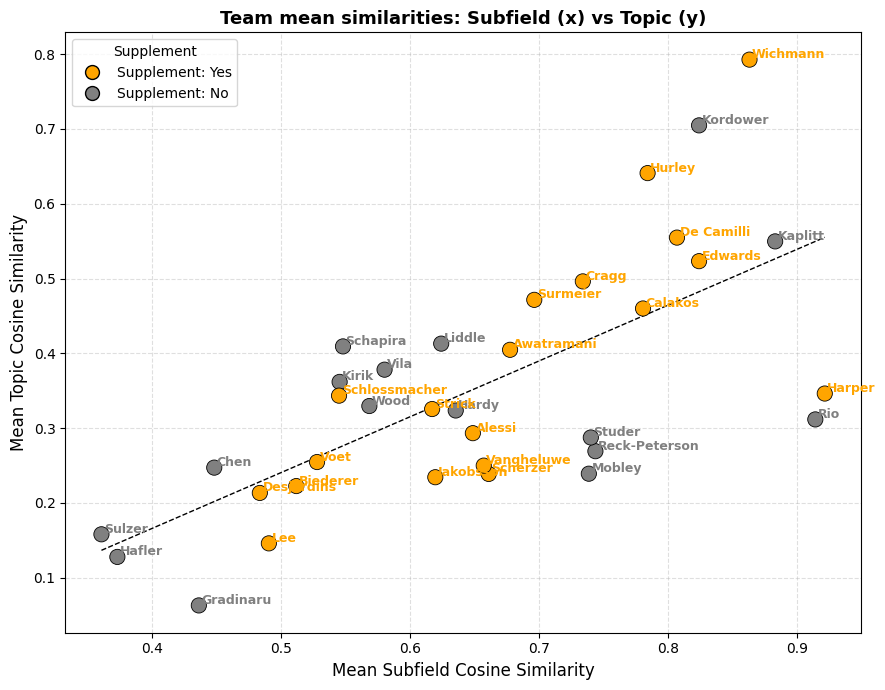

Pearson r = 0.692, p-value = 0.0000


,Team,Supplement,Mean_Topic_Cosine,Mean_Subfield_Cosine
0,Wichmann,Yes,0.792619,0.862951
1,Kordower,No,0.704733,0.823888
2,Hurley,Yes,0.640928,0.784023
3,De Camilli,Yes,0.554719,0.806774
4,Kaplitt,No,0.549649,0.882826


In [80]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

# ---- Assumptions: df exists and has these columns ----
# df['Team'], df['Supplement'], df['TopicVector'], df['SubFieldVector']
# TopicVector and SubFieldVector should be list-like (e.g., lists or arrays)

# Optional: ensure TopicVector and SubFieldVector are numpy arrays (safe conversion)
def ensure_array(v):
    return np.array(v, dtype=float)

df = df.copy()
df['TopicVector'] = df['TopicVector'].apply(ensure_array)
df['SubFieldVector'] = df['SubFieldVector'].apply(ensure_array)

# ---- compute mean pairwise cosine similarity per team for both vector types ----
teams = []
supps = []
mean_topic_cos = []
mean_subfield_cos = []

for team, group in df.groupby('Team'):
    teams.append(team)
    supps.append(group['Supplement'].iloc[0] if 'Supplement' in group.columns else np.nan)
    n = len(group)

    # Topic
    if n >= 2:
        topic_stack = np.vstack(group['TopicVector'].values)            # shape (n, d)
        sim_topic = cosine_similarity(topic_stack)                      # (n, n) matrix
        pairwise_topic = [sim_topic[i, j] for i, j in itertools.combinations(range(n), 2)]
        mean_topic_cos.append(np.mean(pairwise_topic))
    else:
        mean_topic_cos.append(np.nan)  # not enough members to compute pairwise

    # Subfield
    if n >= 2:
        sub_stack = np.vstack(group['SubFieldVector'].values)
        sim_sub = cosine_similarity(sub_stack)
        pairwise_sub = [sim_sub[i, j] for i, j in itertools.combinations(range(n), 2)]
        mean_subfield_cos.append(np.mean(pairwise_sub))
    else:
        mean_subfield_cos.append(np.nan)

df_means = pd.DataFrame({
    'Team': teams,
    'Supplement': supps,
    'Mean_Topic_Cosine': mean_topic_cos,
    'Mean_Subfield_Cosine': mean_subfield_cos
})

# ---- prepare plotting dataframe (drop teams without both means) ----
df_plot = df_means.dropna(subset=['Mean_Topic_Cosine', 'Mean_Subfield_Cosine']).reset_index(drop=True)
if df_plot.empty:
    raise ValueError("No teams have >=2 members for both Topic and SubField vectors. Nothing to plot.")

# color mapping
color_map = {'Yes':'orange', 'No':'grey'}
df_plot['Color'] = df_plot['Supplement'].map(color_map).fillna('grey')

# ---- Scatter plot ----
plt.figure(figsize=(9,7))
x = df_plot['Mean_Subfield_Cosine']
y = df_plot['Mean_Topic_Cosine']
colors = df_plot['Color']

# points
plt.scatter(x, y, c=colors, s=120, edgecolor='black', linewidth=0.6, zorder=3)

# labels (color+bold to match point color)
for _, row in df_plot.iterrows():
    plt.text(row['Mean_Subfield_Cosine'] + 0.002,   # slight offset
             row['Mean_Topic_Cosine'] + 0.002,
             row['Team'],
             fontsize=9,
             fontweight='bold',
             color=row['Color'],
             zorder=4)

plt.xlabel('Mean Subfield Cosine Similarity', fontsize=12)
plt.ylabel('Mean Topic Cosine Similarity', fontsize=12)
plt.title('Team mean similarities: Subfield (x) vs Topic (y)', fontsize=13, fontweight='bold')

# regression line (simple least squares)
m, b = np.polyfit(x, y, 1)
xs = np.linspace(x.min(), x.max(), 100)
plt.plot(xs, m*xs + b, color='black', linestyle='--', linewidth=1, zorder=2)

# legend
handles = [
    plt.Line2D([0],[0], marker='o', color='w', label='Supplement: Yes', markerfacecolor='orange', markersize=10, markeredgecolor='black'),
    plt.Line2D([0],[0], marker='o', color='w', label='Supplement: No',  markerfacecolor='grey',  markersize=10, markeredgecolor='black')
]
plt.legend(handles=handles, title='Supplement', loc='best')

plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("cosine_similarity_scatterplot_topic_and_subfield.png")
plt.show()

# ---- correlation between means ----
r, p = pearsonr(x, y)
print(f'Pearson r = {r:.3f}, p-value = {p:.4f}')

# ---- also return df_means for convenience ----
df_means_sorted = df_means.sort_values('Mean_Topic_Cosine', ascending=False)
df_means_sorted.reset_index(drop=True, inplace=True)
df_means_sorted.head()
